In [1]:
import importlib
import os, pandas as pd, numpy as np
from joblib import dump, load

import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
# from sod.core.dataset import open_dataset # , normalize_df
# from sod import plot

is_outlier = sod_core_dataset.is_outlier

maindir = os.path.abspath(os.path.join(os.getcwd(), '..',
                                       'evaluations/results/eval.allset_train_test.iforest.yaml/evalreports/'))
assert os.path.isdir(maindir)

# THIS ASSUMES YOU ALREADY CREATED THE EVALUATIIN AGGREGATION. SEE AGGREGAT.EVALUATIONS
path = os.path.join(maindir, 'evaluation.all.hdf')


dfr = pd.read_hdf(path)
print('evaulation dataframe.\n\nColumns:\n' + str(dfr.columns.tolist()))
print('\nclassname distinct values:\n' + str(np.unique(dfr['classname'])))

# define the classes of interest (see sod code allset_test)
class_inlier = sod_core_dataset.allset_test.classnames[0] # 'ok' 
class_outlier = sod_core_dataset.allset_test.classnames[1] #'outl. (wrong inv)'
class_me_unknown = sod_core_dataset.allset_test.classnames[2]  # 'unlabeled (Me unknown)'

sel_inlier = sod_core_dataset.allset_test.class_selector[class_inlier]
sel_outlier = sod_core_dataset.allset_test.class_selector[class_outlier]
sel_me_unknown = sod_core_dataset.allset_test.class_selector[class_me_unknown]

evaulation dataframe.

Columns:
['% rec.', 'Mean log_loss', 'behaviour', 'classname', 'clf', 'contamination', 'features', 'max_samples', 'n_estimators']

classname distinct values:
['ok' 'outl. (wrong inv)' 'unlabeled (Me unknown)']


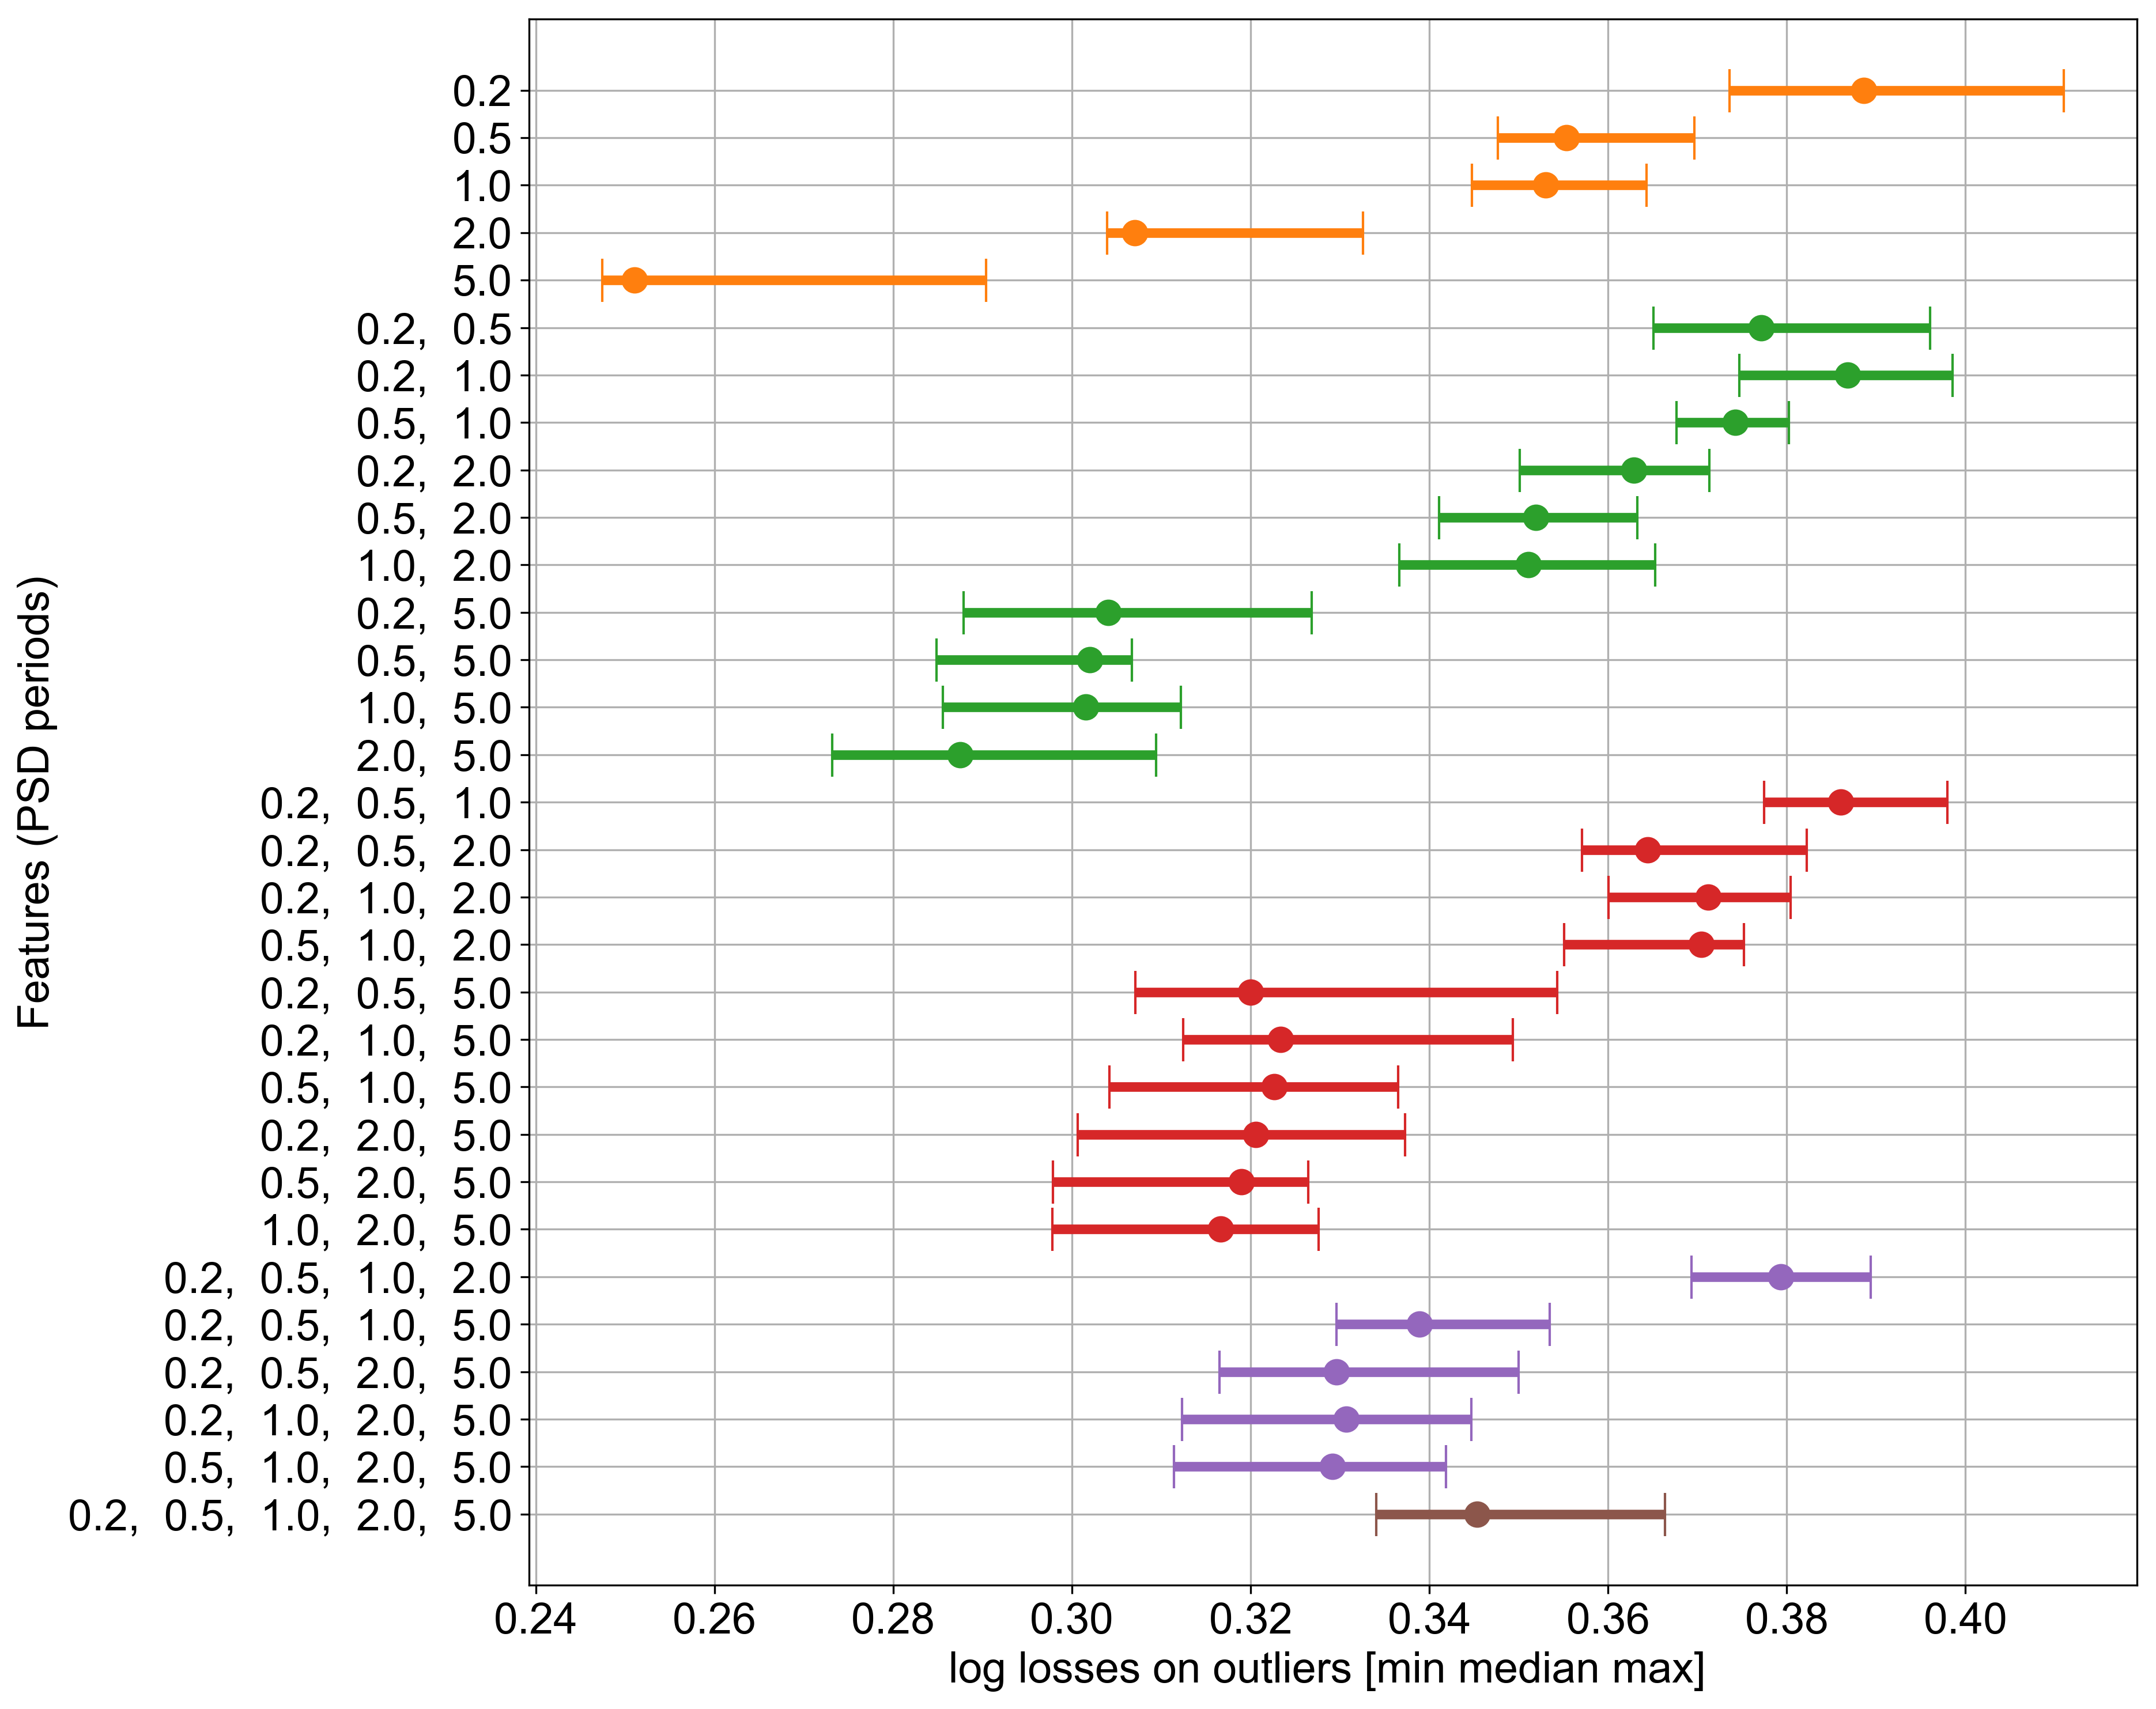

The plot shows that 
1) psd@5seconds is the best feature: when present, scores are lower (less loss=>better)
2) Adding features reduces the score variance but increases the score median, as expected


In [2]:
import matplotlib
importlib.reload(matplotlib)
import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager
from collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

# tmp_fig_size = matplotlib.rcParams['figure.figsize']
# matplotlib.rcParams['figure.figsize']
# plt.rcParams.update({'font.size': 30})
# plt.rcParams.update({'figure.figsize': (22, 22)})


from itertools import cycle
basecolors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# columns = ['features', 'max_samples', 'n_estimators']


colors_ = iter(cycle(basecolors))
colorsdict = defaultdict(lambda: next(colors_))

data = defaultdict(list)
for _, df_ in dfr.groupby('features'):
    data[_].extend(_ for _ in df_[df_.classname.isin([class_outlier])]['Mean log_loss'])


def get_periods(label):
    '''returns the sorted periods from a feature label. E.g. from "psd@0.2sec,psd@5sec" to [0.2, 5]'''
    # label is something like 'psd@0.2sec,psd@5sec'. First grab the periods (0.2, 5):
    return sorted(float(_[:_.rfind('sec')][_.find('@')+1:]) for _ in label.split(','))


def get_color_from_feat_label(label):
    return basecolors[len(get_periods(label))]


labels = sorted(data.keys(),
                # sort by number of features first, and in case same number, by sum of periods then:
                key=lambda f: 1000 * len(get_periods(f)) + sum(get_periods(f)),
                reverse=True)


with plotparams({'figure.figsize': (12, 12), 'font.size': 18, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):

    for i, label in enumerate(labels):
        values = data[label]
        avg = np.quantile(values, 0.5)
        xerr = [[avg-np.nanmin(values)], [np.nanmax(values)-avg]]
        plt.errorbar(avg, i, xerr=xerr, color=get_color_from_feat_label(label),
                     marker='o', capsize=9,
                     linewidth=4, markersize=10)
    # plt.title('Min, Median, Max of mean log loss on outliers\n(colors denote the number of features)')
    lbls = [",  ".join("%.1f" % __ for __ in get_periods(_)) for _ in labels]
    plt.yticks(list(range(len(labels))), lbls)  # ["".join("2.2f" % _ for _ in get_periods(lbl)) for lbl in labels])
    plt.ylabel('Features (PSD periods)')
    plt.xlabel('log losses on outliers [min median max] ')
    plt.grid()
#     plt.yticklabels(labels)

plt.show()


print('The plot shows that ')
print('1) psd@5seconds is the best feature: when present, scores are lower (less loss=>better)')
print('2) Adding features reduces the score variance but increases the score median, as expected')
print('Note however that called D the mean log loss difference between two models.')
print('the mean difference of scores is: 1 - 10 ** D')

In [ ]:
# Let's convert a mean log loss into something readable/edible. A mean log loss difference of D, to which
# score degradation corresponds per segment?
# If we have a sum log loss of a new score, score2, which is greater than a previous log loss on scores1, then:

sum_n logloss(score2) / n - sum_n logloss(score1) / n = 

logloss(s2_1)/n - logloss(s1_1)/n + ... + logloss(s2_n)/n - logloss(s1_n)/n =

# called d the distance from optimum, d is 1-score for OUTLIERS, and score for inliers.
# dN_M = distance from optimum of segment M belonging to set N
# WE replace logloss as -log(d):

-log(d2_1) + log(d1_1) + ... -log(d2_n) + log(d1_n)

10 ** [log(d1_1) + log(d1_n)] * 10 ** (-[log(d2_1) + log(d2_n)])

(d1_1 + .. + d1_n) * 1 / (d2_1+ ... + d2_n) = exp(sum_n logloss(score2) - sum_n logloss(score1))

sum of distances of scores 1 from optimum / sum of distances of scores 2 from optimum

# so exp(positive_diff_of_avg_loglosses) is equal to:

1/(d2_1) + (d1_1) + ... 1/(d2_n) + (d1_n) 

(1- d1_1) + ... (1+d1_n) + 1/(d2_1) +... + 1/(d2_n)

n - sum(disances_from_optimum_scores1) + sum(distances_from_optimumj_scores2)
 

avg1 = sum_n logloss(score1)/n
avg2 = sum_n logloss(score2)/n

and we suppose avg1 < avg2, then

avg2 - avg1 = ( sum_n logloss(score2) - sum_n logloss(score1) ) / n

n (avg2 - avg1) = [logloss(s2_1) - logloss(s1_1)] + ... + [logloss(s2_n) - logloss(s1_n)]

10 ^ (n (avg2 - avg1)) = 10 ** ([logloss(s2_1) - logloss(s1_1)] + ... + [logloss(s2_n) - logloss(s1_n)])
                   
# FOR OUTLIERS:
                       = 10 ** ([-log(1-s2_1) + log(1-s1_1)] + ... + [-log(1-s2_n) + log(1-s1_n)] )
    
                       = (1-s2_1) ** -1 + (1-s1_1) + ... + (1-s2_n) ** -1 + (1-s1_n)

    = (10 ** ([log(1-s21) - log(1-s11)] + ... + [log(1-s2n) - log(1-s1n)])) ^^ (1/n)
        
                   = ([1-s21 - 1 + s11 ... +1-s2n -1+s1n]) ^^ (1/n)
            
                   = (s11-s21 + ... + s1n - s2n) ^^ (1/n)

10 ^ (-n * (avg2 - avg1)) = -s21 + s11 + ... -s2n + s1n

10 ^ (-n * (avg2 - avg1)) = s11 - s21 + ... s1n - s2n

10 ^ (-n * (avg2 - avg1)) / n = (s11 - s21 + ... s1n - s2n) / n





Given two OUTLIERS predicted with p1 and p2, then:

logloss1 = -log(1-p1)
logloss2 = -log(1-p2)

I.e., called d as the "distance from 1", then 1-p1=d1 and 1-p2=d2:
logloss1 = -log(d1)
logloss2 = -log(d2)
    
Assuming d1 > d2, i.e. logloss1 < logloss2, then the log loss difference is:
logloss2 - logloss1  = -log(d2) + log(d1)

The loglossdiff will be called as D. It is the difference between the greater loss and the lower loss. Then:
D = -(log(d2) - log(d1)) = -log(d2/d1)
with d2 < d1, i.e. d2 / d1 < 1.
Then:
d2/d1 = 10 ** -D 
    
if abs(l1-l2) == d, then
d = abs(-log(1-p1)+log(1-p2)) = log(1-p1) – log(1-p2) if l1 >= l2
10d = (1-p1)/(1-p2)


50
100
200


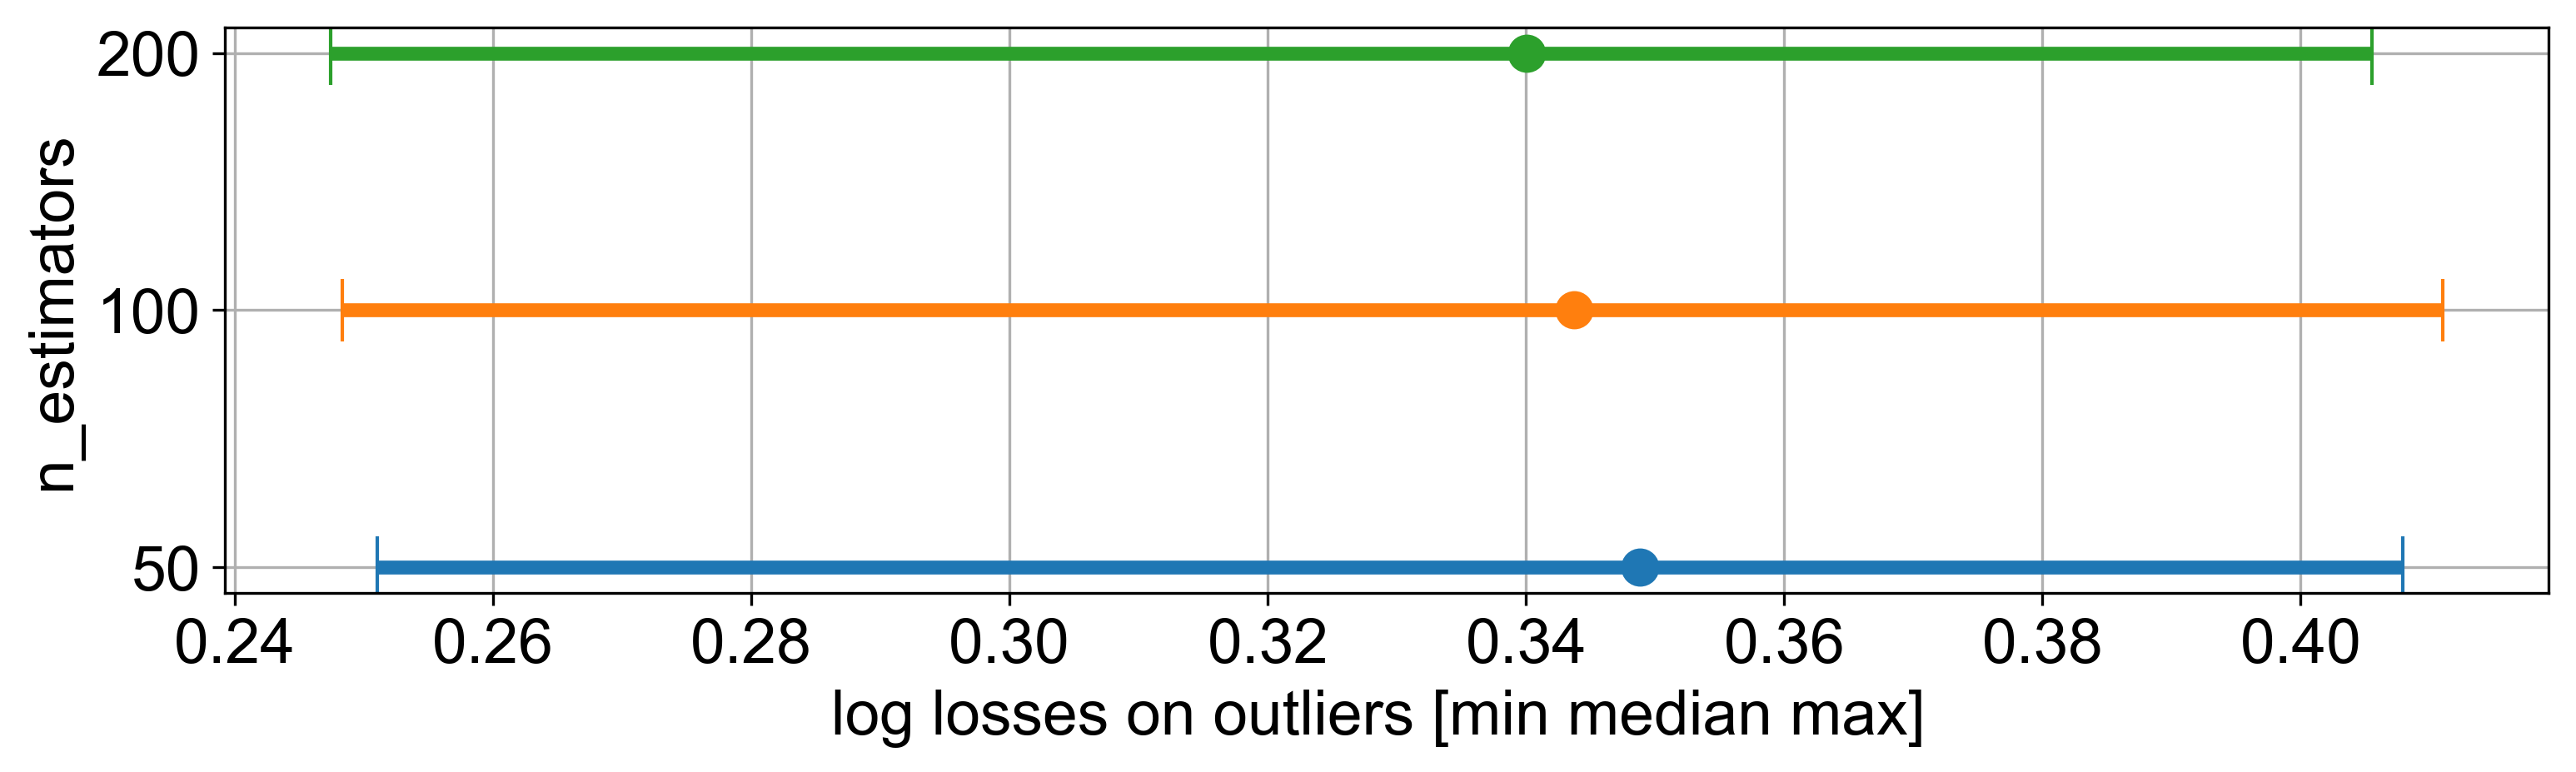

512
2048
8192


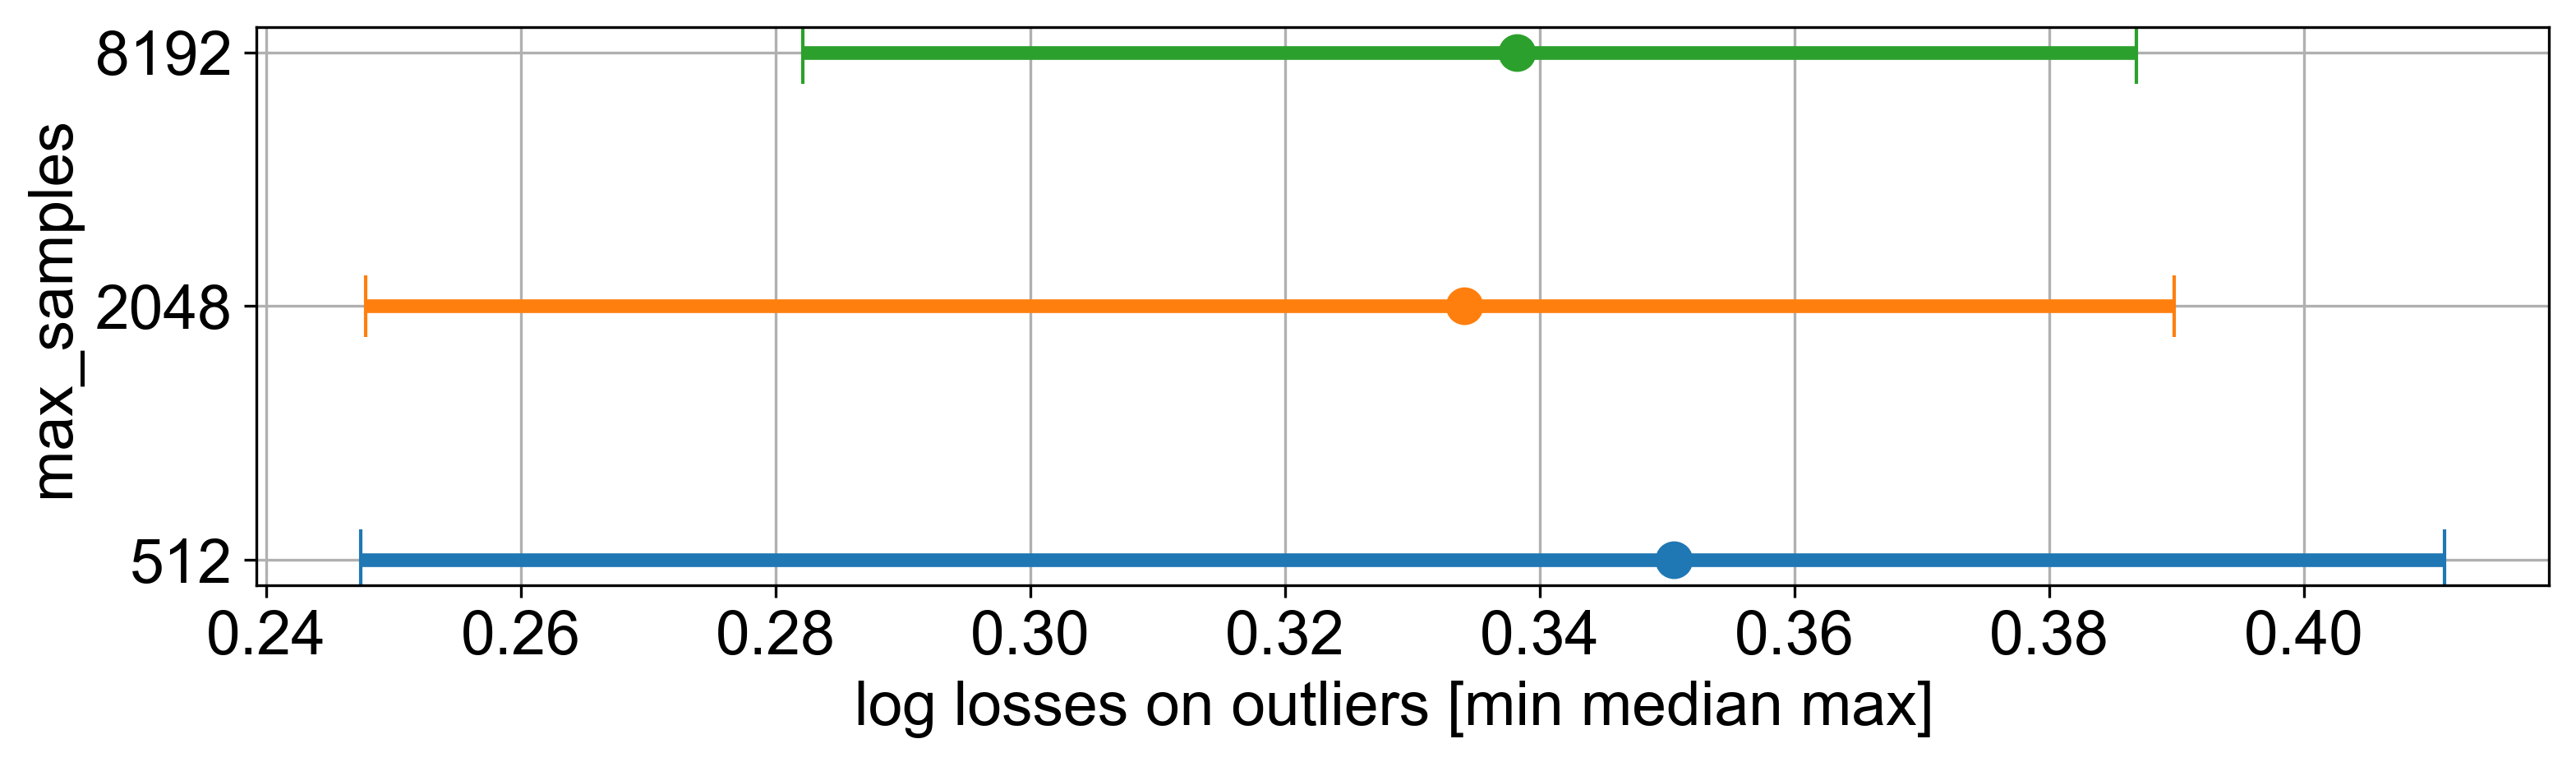

In [8]:
# ================================================================================================

# now print the hyperparameters

for param in ['n_estimators', 'max_samples']:
    data = defaultdict(list)

    labels = []
    for _, df_ in dfr.groupby(param):
        print(_)
        labels.append(_)
        data[_].extend(_ for _ in df_[df_.classname.isin([class_outlier])]['Mean log_loss'])


    with plotparams({'figure.figsize': (12, 3), 'font.size': 18, 'figure.dpi': 150, 'font.family': 'helvetica,arial'}):

        for i, label in enumerate(labels):
            values = data[label]
            avg = np.quantile(values, 0.5)
            xerr = [[avg-np.nanmin(values)], [np.nanmax(values)-avg]]
            plt.errorbar(avg, i, xerr=xerr,
                         marker='o', capsize=9,
                         linewidth=4, markersize=10)
        # plt.title('Min, Median, Max of mean log loss on outliers\n(colors denote the number of features)')
        lbls = labels # [",  ".join("%.1f" % __ for __ in get_periods(_)) for _ in labels]
        plt.yticks(list(range(len(labels))), lbls)  # ["".join("2.2f" % _ for _ in get_periods(lbl)) for lbl in labels])
        plt.ylabel(param)
        plt.xlabel('log losses on outliers [min median max] ')
        plt.grid()
        plt.show()
    # print(pd.Series(avg))

In [30]:
# for a further check, let's print the data of the plot above as pandas dataframes


# displaying the scores. SKIP THIS


# import matplotlib
# importlib.reload(matplotlib)
# import numpy as np
# import matplotlib.pyplot as plt
# from contextlib import contextmanager
# from collections import defaultdict

# %matplotlib inline

# @contextmanager
# def plotparams(params):
#     '''makes temporarily matplotlib params.
#     Make sure to run this after %matplotlib inline.
#     For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
#     def_params = {k: plt.rcParams[k] for k in params}
#     for k, v in params.items():
#         plt.rcParams[k] = v
#     try:
#         yield
#     finally:
#         for k, v in def_params.items():
#             plt.rcParams[k] = v

# from itertools import cycle
# basecolors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

columns = ['MLL on inliers', 'MLL on outliers', 'AVG MLL']

data = []
index=[]

for feat, df_ in dfr.groupby('features'):
    row = [
        df_[df_.classname == 'ok']['Mean log_loss'].median(),
        df_[df_.classname == 'outl. (wrong inv)']['Mean log_loss'].median(),
        df_[df_.classname.isin(['ok', 'outl. (wrong inv)'])]['Mean log_loss'].median()
    ]
    index.append(feat)
    data.append(row)

print('Mean log loss (MLL) per features')
print()

datafr = pd.DataFrame(index=index, data=data, columns=columns)
print()
print('Sorted by MLL on inliers')
print(datafr.sort_values(['MLL on inliers']).to_string())

datafr = pd.DataFrame(index=index, data=data, columns=columns)
print()
print('Sorted by MLL on outliers')
print(datafr.sort_values(['MLL on outliers']).to_string())

datafr = pd.DataFrame(index=index, data=data, columns=columns)
print()
print('Sorted by AVG MLL, i.e. average(MLL on inliers, MLL on outliers)')
print(datafr.sort_values(['AVG MLL']).to_string())


Mean log loss (MLL) per features


Sorted by MLL on inliers
                                                  MLL on inliers  MLL on outliers   AVG MLL
psd@0.2sec,psd@1sec,psd@2sec,psd@5sec                    0.52625          0.33068  0.427895
psd@0.5sec,psd@1sec,psd@2sec,psd@5sec                    0.52788          0.32914  0.427740
psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec,psd@5sec         0.53019          0.34536  0.436295
psd@0.2sec,psd@0.5sec,psd@2sec,psd@5sec                  0.53038          0.32961  0.431010
psd@0.2sec,psd@0.5sec,psd@1sec,psd@5sec                  0.53125          0.33891  0.433965
psd@0.2sec,psd@0.5sec,psd@1sec,psd@2sec                  0.53405          0.37930  0.454395
psd@1sec,psd@2sec,psd@5sec                               0.53685          0.31661  0.423525
psd@0.2sec,psd@2sec,psd@5sec                             0.53934          0.32054  0.426980
psd@0.5sec,psd@2sec,psd@5sec                             0.54019          0.31896  0.424040
psd@0.2sec,psd@1sec,

In [12]:
print('Final decision: we take the best model in recognizing outliers (i.e., with minimum log loss on outliers)')
print('Among the best, we choose actually the first that has t=50 because is way more efficient')
print('We then take the best model with average los loss, and t=50')
print('Among the best, we choose actually the second best because it has t=50 and is way more efficient')

print('TODO: take also the best two models overall, to compare performances afterwards and check that we do not')
print('decrease too much')

# best average, best outlier, best inlier
# best average t=50, best outlier t=50, best inlier t=50
# best average t=50 , best outlier t=50, best inlier t=50

import pandas as pd

# adding the two best with two features, with contamination 5% an 10%
fnames = {
    # 'best_avg_t50': 'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
    'best_avg': 'IsolationForest?features=psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200',
    # 'best_out_same_t_psi': 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
    # 'best_inl_same_t_psi': 'IsolationForest?features=psd@0.2sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
    # 'best_inl_t50': 'IsolationForest?features=psd@0.2sec,psd@1sec,psd@2sec,psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50',
    'best_outl_t50': 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50',
    'best_outl_t100': 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100',
    'best_outl': 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=200',
}

print()
print('Loading models and predictions')
rootdir = maindir.replace('evalreports', '')
clfs = {k: load(os.path.join(rootdir, 'models', v + '.model')) for k, v in fnames.items()}
pred_dfs = {k: pd.read_hdf(os.path.join(rootdir, 'predictions', v + '.hdf')) for k, v in fnames.items()}

for n, c in clfs.items():
    print('%s: %s' % (str(n), str(c)))
# print('loading source trainset')
# dataframe = sod_core_dataset.open_dataset('allset_train.hdf', normalize=False, verbose=False)

Final decision: we take the best model in recognizing outliers (i.e., with minimum log loss on outliers)
Among the best, we choose actually the first that has t=50 because is way more efficient
We then take the best model with average los loss, and t=50
Among the best, we choose actually the second best because it has t=50 and is way more efficient
TODO: take also the best two models overall, to compare performances afterwards and check that we do not
decrease too much

Loading models and predictions
best_avg: IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=2048, n_estimators=200,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
best_outl_t50: IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=512, n_estimators=50, n_jobs=None,
                random_state=None, verbose=0, warm_start=False)
best_outl_t100: IsolationForest(b

In [13]:
print()
npts = 1000000
print('Some estimations on time performances predicting %d instances' % npts)
data = np.random.uniform(low=-200, high=-60, size=(npts,)).reshape((npts, 1))

import time
for n, c in clfs.items():
    try:
        t = time.time()
        preds = -c.score_samples(data)
        print('%s: %f seconds' % (n, time.time() - t))
    except Exception as exc:
        print('Skipping %s: %s:' % (n, str(exc)))



Some estimations on time performances predicting 1000000 instances
Skipping best_avg: Number of features of the model must match the input. Model n_features is 2 and input n_features is 1.:
best_outl_t50: 12.210344 seconds
best_outl_t100: 27.587922 seconds
best_outl: 45.029164 seconds


SCORES DISTRIBUTIONS ON SEGMENTS: INLIERS + OUTLIERS + ME UNKNOWN
best_avg


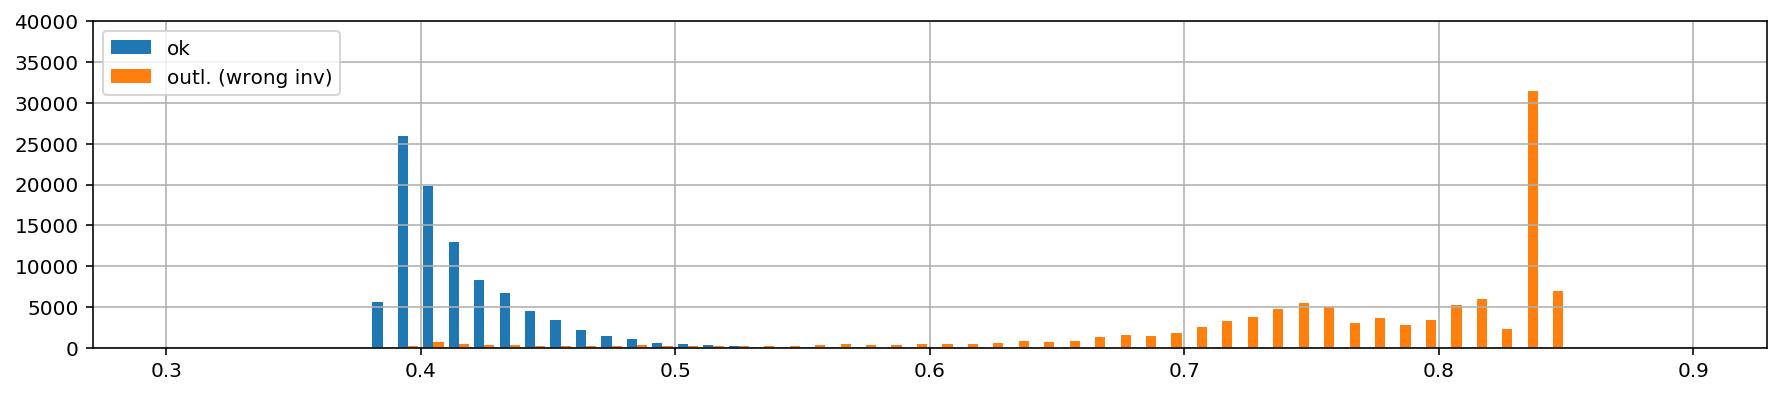

best_outl_t50


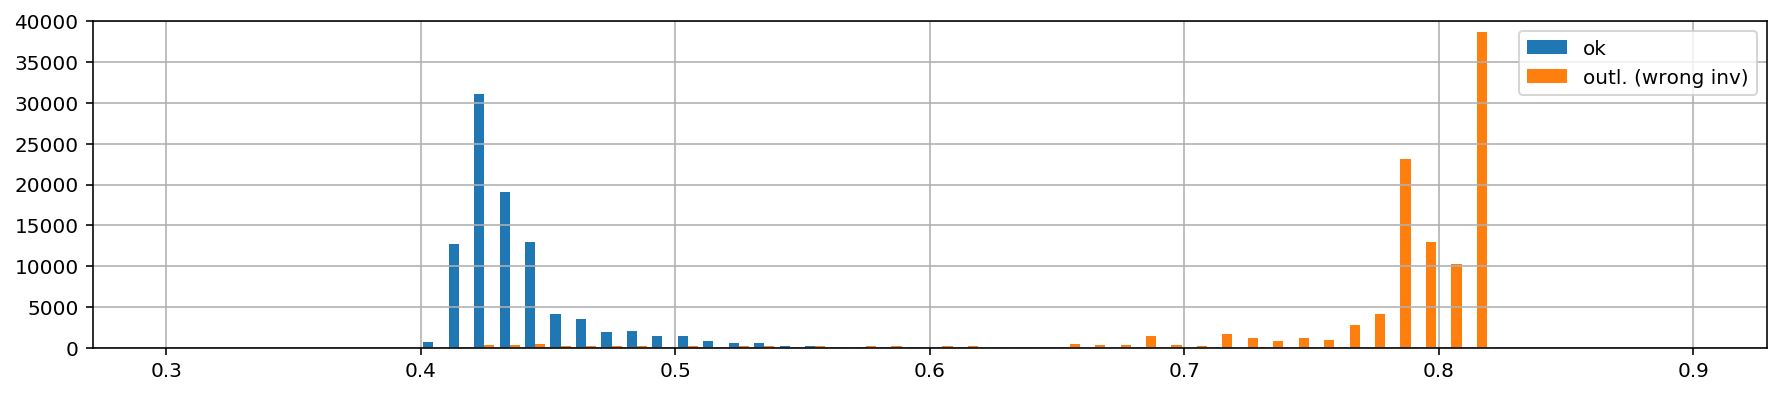

best_outl_t100


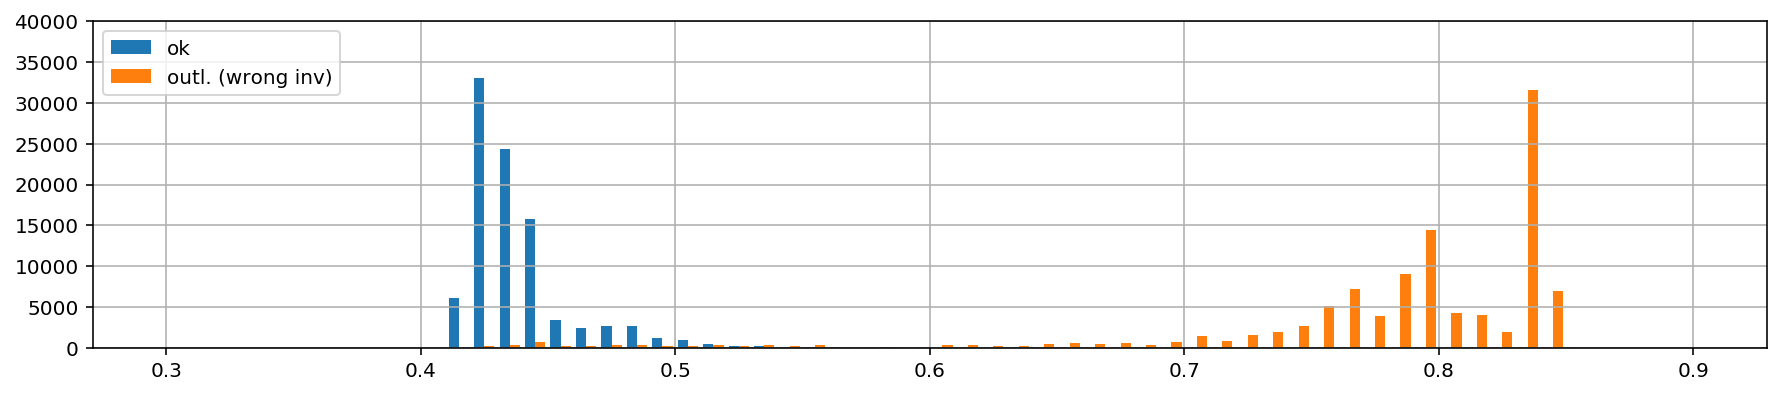

best_outl


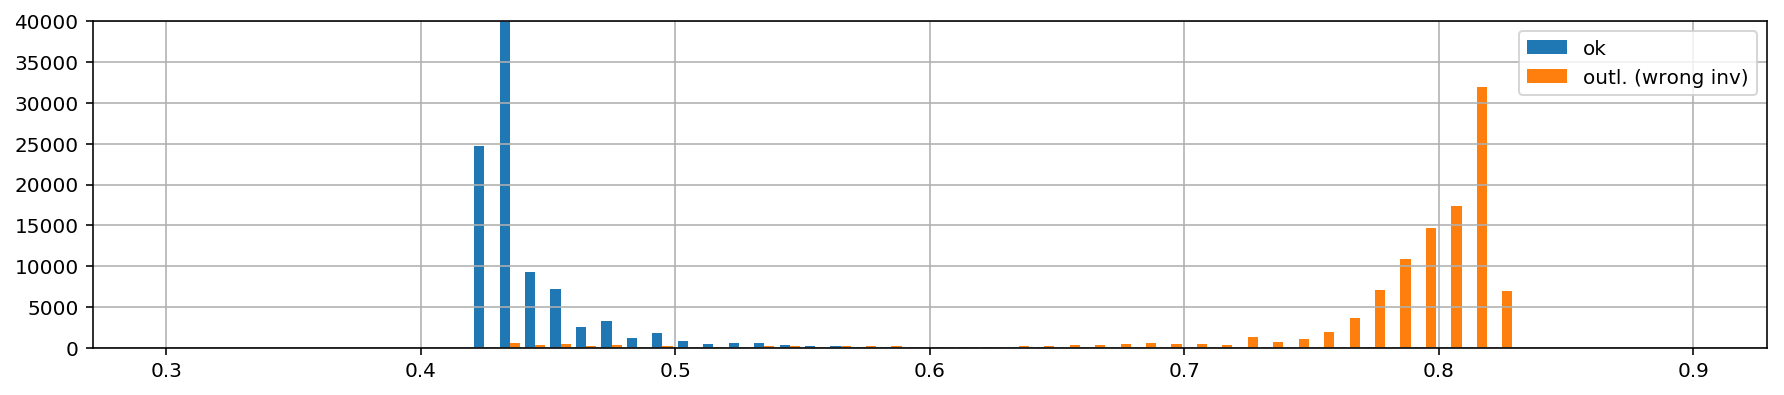

In [14]:
from sod.core.dataset import dataset_info, allset_test


class_inlier = allset_test.classnames[0]
class_outlier = allset_test.classnames[1]
class_me_unknown = allset_test.classnames[2]

sel_inlier = allset_test.class_selector[class_inlier]
sel_outlier = allset_test.class_selector[class_outlier]
sel_me_unknown = allset_test.class_selector[class_me_unknown]


import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)

print('SCORES DISTRIBUTIONS ON SEGMENTS: INLIERS + OUTLIERS + ME UNKNOWN')

%matplotlib inline
import numpy as np
bins = np.arange(0.3, .9, 0.01)
with plotparams({'figure.figsize': (15, 3)}):
    for name, pred_df in pred_dfs.items():
        print(name)
        data = [
            pred_df[sel_inlier(pred_df)].predicted_anomaly_score,
            pred_df[sel_outlier(pred_df)].predicted_anomaly_score,
            # pred_df[sel_me_unknown(pred_df)].predicted_anomaly_score
        ]
        
        plt.hist(data, bins=bins, log=False, histtype='bar', stacked=False, label=[class_inlier, class_outlier, class_me_unknown])
        plt.grid()
        plt.ylim([1, 40000]) #  10**5])
        plt.legend()
        plt.show()


ROC curves



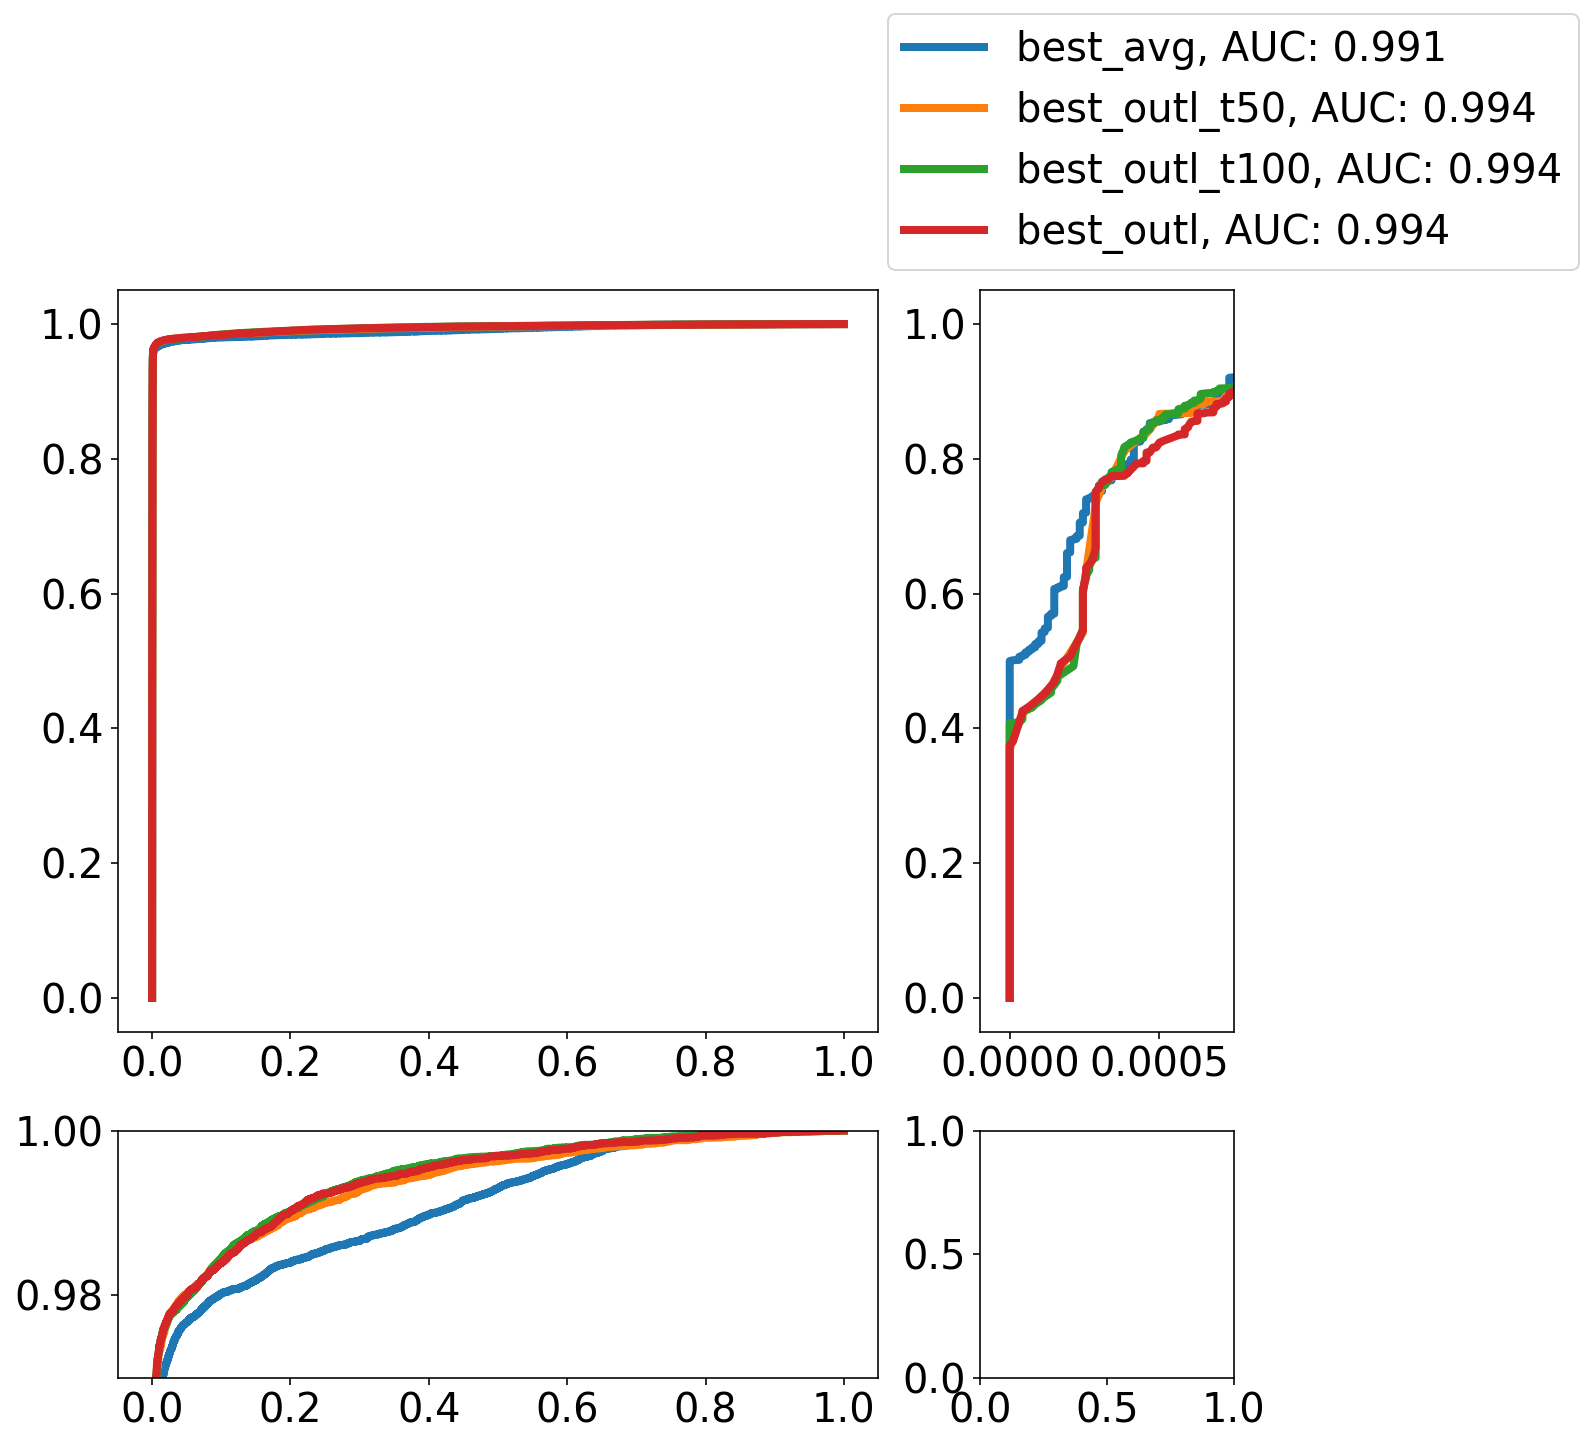

In [18]:
# print auc:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc


print('\nROC curves')
print()

roc_curve_data = {}
                                         
with plotparams({'figure.figsize': (10, 10), 'font.size': 20}):
    fig, ax = plt.subplots(2,2, gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [3, 1]})
    for name, pred_df in pred_dfs.items():
        _pred_df = pred_df[sel_inlier(pred_df)| sel_outlier(pred_df)]
        fpr, tpr, thresholds = roc_curve(_pred_df.outlier, _pred_df.predicted_anomaly_score, drop_intermediate=True)
        roc_curve_data[name] = (fpr, tpr, thresholds)
        for a in [ax[0][0], ax[0][1], ax[1][0]]:
            a.plot(fpr, tpr,
                     label=name + ', AUC: %.3f' % auc(fpr, tpr),
                     linewidth=4) # , marker='o')
            a.grid()
        ax[0][1].set_xlim([-0.0001, 0.00075])
        ax[1][0].set_ylim([0.97, 1])
        ax[0][1].legend(loc='lower center', bbox_to_anchor=(1, 1))
#     plt.legend()
#     plt.grid()
#     plt.xlim([0.1, 1])
#     plt.ylim([0.98, 1])
    plt.show()

Average % correctly predicted by score threshold


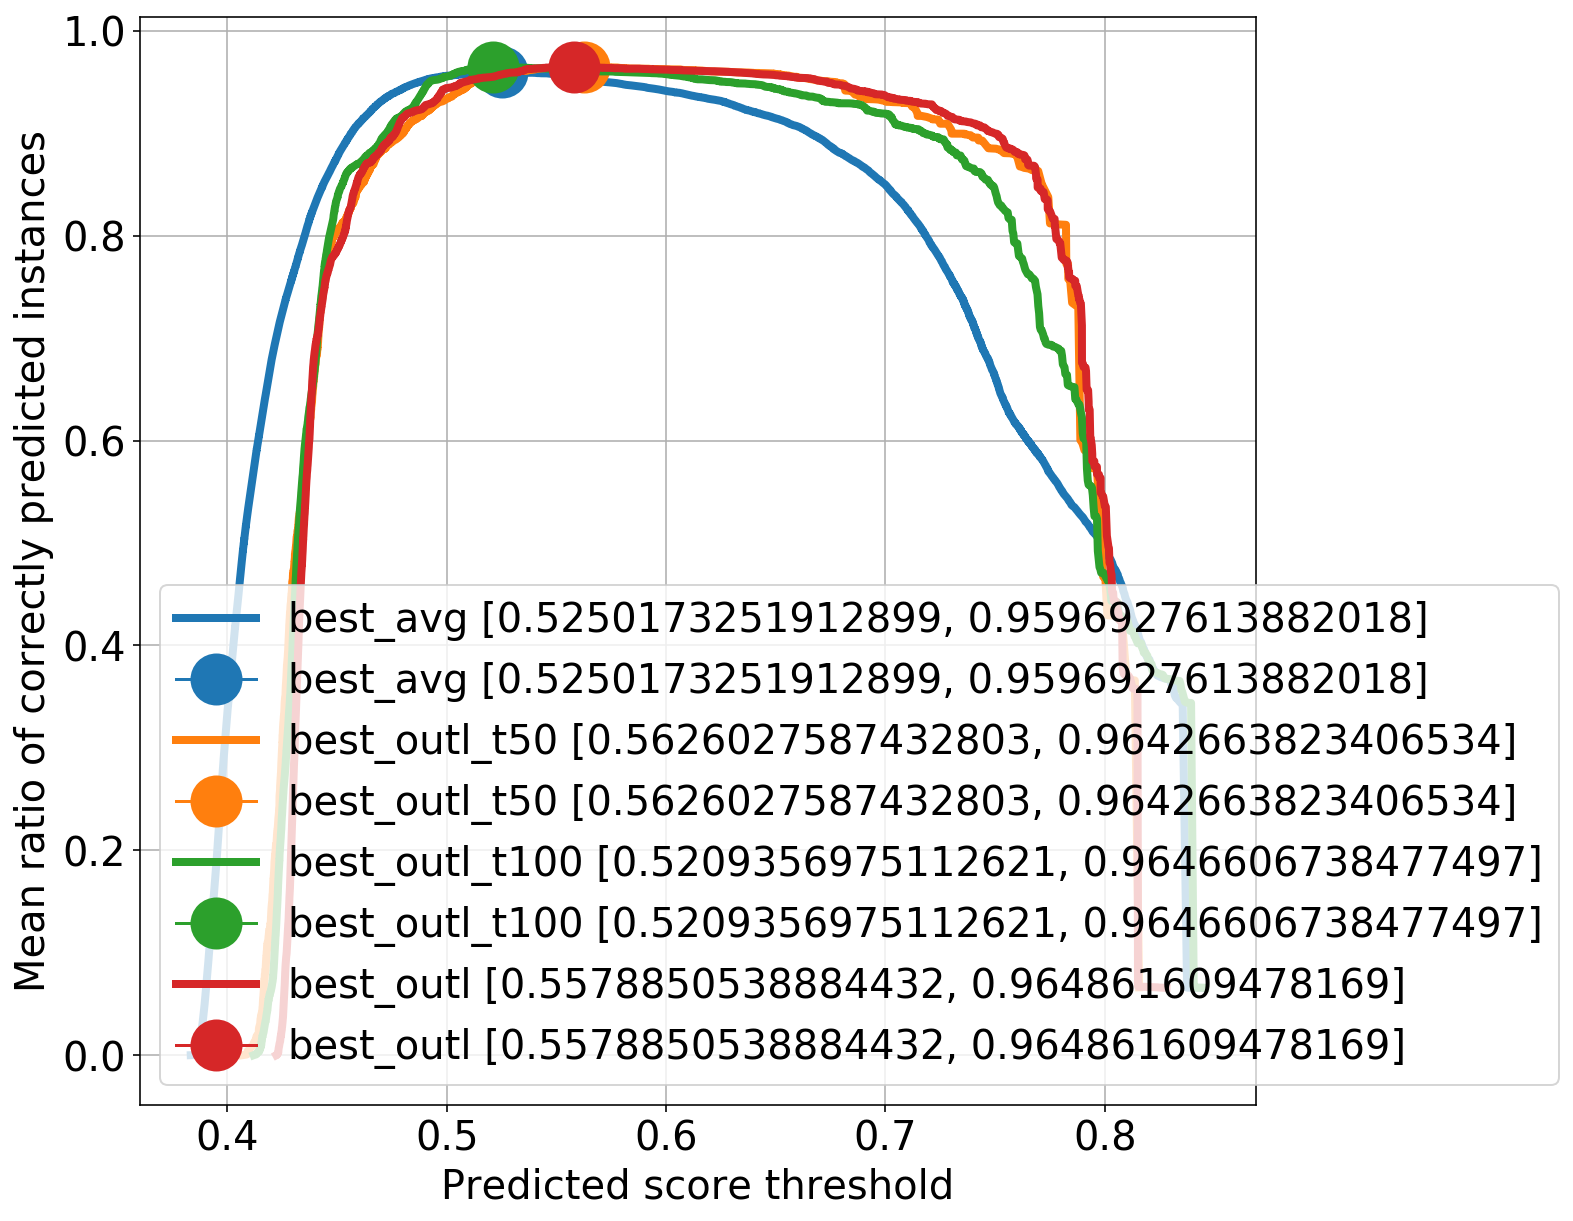

The best outlier has a borader range where the mean % of recognition is stable and higher
For that model, the plot above says that by setting thresholds between .55 and .65 you get the best percentage of correctly classified instances
The green line basically says that the optimum separation is between 0.55 and 0.65: above that threshold
the higher the score, the more likely the segment is an outlier, the lower the score, the more likely the segment is not an outlier
Setting higher or lower thresholds depends on the usage:
Lower thresholds mean the user wants to be more strict about discarding all outliers (at the cost of trhowing away some inliers, and thus more data, because inliers are in principle more) 
Higher thresholds mean the user wants to be more strict about keeping all inliers (at the cost of not trhowing away some outliers, and thus keeping more data, because outliers are in principle more) 

Offsets
{}


In [16]:
offsets = {}

print('Average % correctly predicted by score threshold')

with plotparams({'figure.figsize': (10, 10), 'font.size': 20}):
    for name, (fpr, tpr, thresholds) in roc_curve_data.items():
#         data_ = {}
#         for x, y, th in zip(fpr[::-1], tpr[::-1], thresholds[::-1]):
#             if th < 0 or th > 1:
#                 continue
#             key_ = int(0.5+th*50)
#             data_[key_] = (th, np.round(x,2), np.round(y,2), np.round(((1-x)+y)/2.0, 5))
#         statdfr = pd.DataFrame(list(data_.values()),
#                                columns=['TH', 'FPR: 1-(% of CP(inliers))', 'TPR: : % of CP(outliers)', '% CP (mean)'])
#         offsets[name] = 0.5 - statdfr[statdfr['% CP (mean)'] == statdfr['% CP (mean)'].max()]['TH'].values[0]
#         print()
#         print(name)
#         print(statdfr.to_string(index=False))
        x, y = thresholds[1:], (1-fpr[1:])*tpr[1:]
        xmax, ymax = x[np.argmax(y)], y[np.argmax(y)]
        label = name + ' ' + str([xmax, ymax])
        p = plt.plot(x, y,
                 label=label,
                 linewidth=4)
        clr = p[0].get_color()
        plt.plot(x[np.argmax(y)], y[np.argmax(y)], marker='o', markersize=25, label=label, color=clr)
    plt.legend()
    plt.xlabel('Predicted score threshold')
    plt.ylabel('Mean ratio of correctly predicted instances')
    plt.grid()
    # plt.xlim([0, 0.1])
    plt.show()
    
print('The best outlier has a borader range where the mean % of recognition is stable and higher')
print('For that model, the plot above says that by setting thresholds between .55 and .65 you get the best percentage of correctly classified instances')
# print('No inlier has been classified with scores >=.62, some outlier (2%) has been classified with scores <0.52')
print('The green line basically says that the optimum separation is between 0.55 and 0.65: above that threshold')
print('the higher the score, the more likely the segment is an outlier, the lower the score, the more likely the segment is not an outlier')
print('Setting higher or lower thresholds depends on the usage:')
print('Lower thresholds mean the user wants to be more strict about discarding all outliers (at the cost of trhowing away some inliers, and thus more data, because inliers are in principle more) ')
print('Higher thresholds mean the user wants to be more strict about keeping all inliers (at the cost of not trhowing away some outliers, and thus keeping more data, because outliers are in principle more) ')

print()
print('Offsets')
print(offsets)

Average % correctly predicted by score threshold

best_avg_t50
TH  FPR: 1-(% of CP(inliers))  TPR: : % of CP(outliers)  % CP (mean)
0.390000                       0.88                      1.00      0.56187
0.409999                       0.43                      0.99      0.78096
0.429998                       0.22                      0.98      0.88062
0.449991                       0.11                      0.98      0.93293
0.469992                       0.05                      0.98      0.96142
0.489976                       0.02                      0.97      0.97408
0.510000                       0.01                      0.97      0.97920
0.529948                       0.01                      0.96      0.97944
0.549930                       0.00                      0.96      0.97924
0.569953                       0.00                      0.95      0.97639
0.589883                       0.00                      0.95      0.97258
0.609893                       0.00        

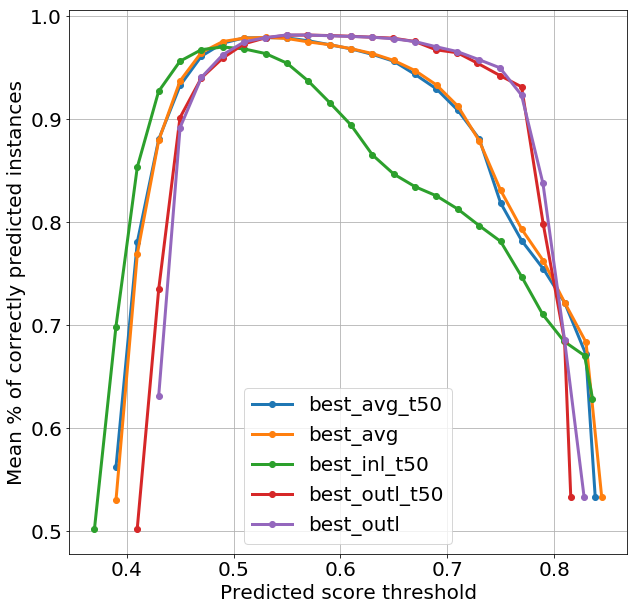

The best outlier has a borader range where the mean % of recognition is stable and higher
For that model, the plot above says that by setting thresholds between .55 and .65 you get the best percentage of correctly classified instances
The green line basically says that the optimum separation is between 0.55 and 0.65: above that threshold
the higher the score, the more likely the segment is an outlier, the lower the score, the more likely the segment is not an outlier
Setting higher or lower thresholds depends on the usage:
Lower thresholds mean the user wants to be more strict about discarding all outliers (at the cost of trhowing away some inliers, and thus more data, because inliers are in principle more) 
Higher thresholds mean the user wants to be more strict about keeping all inliers (at the cost of not trhowing away some outliers, and thus keeping more data, because outliers are in principle more) 

Offsets
{'best_avg_t50': -0.029947821583554912, 'best_avg': -0.029995885632446373

In [146]:
offsets = {}

print('Average % correctly predicted by score threshold')

with plotparams({'figure.figsize': (10, 10), 'font.size': 20}):
    for name, (fpr, tpr, thresholds) in roc_curve_data.items():
        data_ = {}
        for x, y, th in zip(fpr[::-1], tpr[::-1], thresholds[::-1]):
            if th < 0 or th > 1:
                continue
            key_ = int(0.5+th*50)
            data_[key_] = (th, np.round(x,2), np.round(y,2), np.round(((1-x)+y)/2.0, 5))
        statdfr = pd.DataFrame(list(data_.values()),
                               columns=['TH', 'FPR: 1-(% of CP(inliers))', 'TPR: : % of CP(outliers)', '% CP (mean)'])
        offsets[name] = 0.5 - statdfr[statdfr['% CP (mean)'] == statdfr['% CP (mean)'].max()]['TH'].values[0]
        print()
        print(name)
        print(statdfr.to_string(index=False))
        plt.plot(statdfr['TH'], statdfr['% CP (mean)'],
                 label=name,
                 linewidth=3, marker='o')
    plt.legend()
    plt.xlabel('Predicted score threshold')
    plt.ylabel('Mean % of correctly predicted instances')
    plt.grid()
    # plt.xlim([0, 0.1])
    plt.show()
    
print('The best outlier has a borader range where the mean % of recognition is stable and higher')
print('For that model, the plot above says that by setting thresholds between .55 and .65 you get the best percentage of correctly classified instances')
# print('No inlier has been classified with scores >=.62, some outlier (2%) has been classified with scores <0.52')
print('The green line basically says that the optimum separation is between 0.55 and 0.65: above that threshold')
print('the higher the score, the more likely the segment is an outlier, the lower the score, the more likely the segment is not an outlier')
print('Setting higher or lower thresholds depends on the usage:')
print('Lower thresholds mean the user wants to be more strict about discarding all outliers (at the cost of trhowing away some inliers, and thus more data, because inliers are in principle more) ')
print('Higher thresholds mean the user wants to be more strict about keeping all inliers (at the cost of not trhowing away some outliers, and thus keeping more data, because outliers are in principle more) ')

print()
print('Offsets')
print(offsets)

REDOING EVERYTHING WITH CALIBRATION
SCORES DISTRIBUTIONS ON SEGMENTS: INLIERS + OUTLIERS + ME UNKNOWN
best_avg_t50


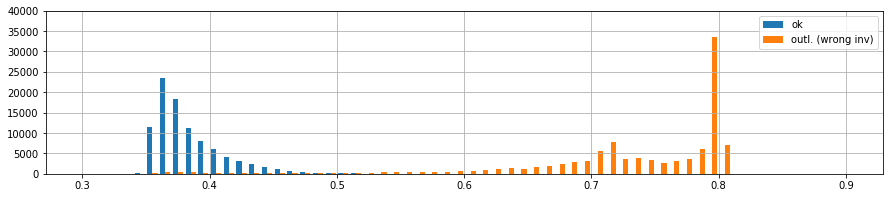

best_avg


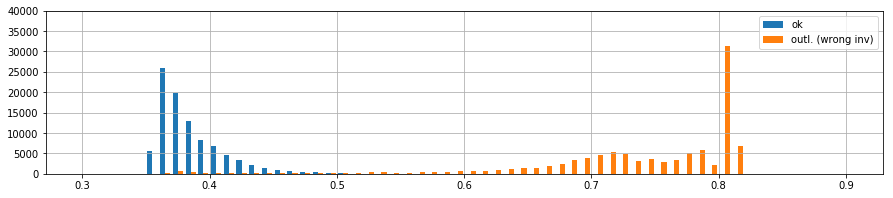

best_inl_t50


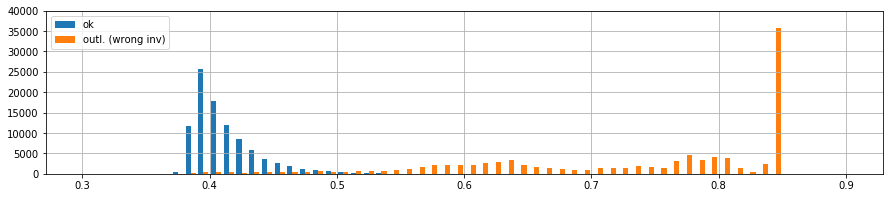

best_outl_t50


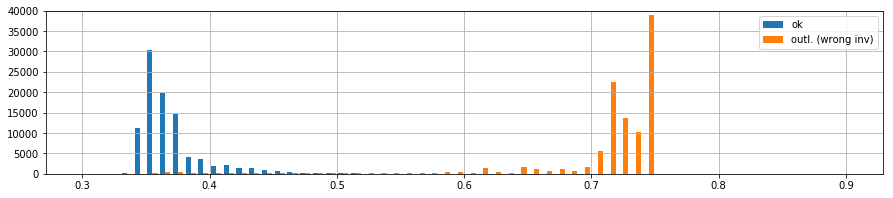

best_outl


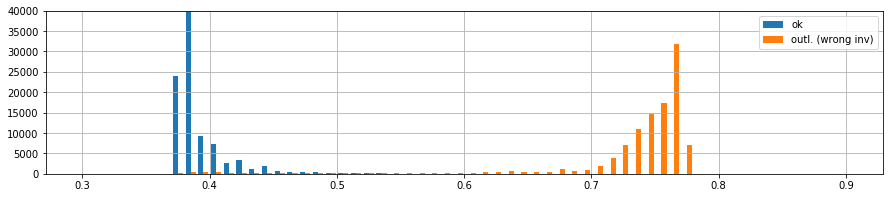

In [147]:
print('REDOING EVERYTHING WITH CALIBRATION')

from sod.core.dataset import dataset_info, allset_test


class_inlier = allset_test.classnames[0]
class_outlier = allset_test.classnames[1]
class_me_unknown = allset_test.classnames[2]

sel_inlier = allset_test.class_selector[class_inlier]
sel_outlier = allset_test.class_selector[class_outlier]
sel_me_unknown = allset_test.class_selector[class_me_unknown]


import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)

print('SCORES DISTRIBUTIONS ON SEGMENTS: INLIERS + OUTLIERS + ME UNKNOWN')

%matplotlib inline
import numpy as np
bins = np.arange(0.3, .9, 0.01)
with plotparams({'figure.figsize': (15, 3)}):
    for name, pred_df in pred_dfs.items():
        print(name)
        data = [
            pred_df[sel_inlier(pred_df)].predicted_anomaly_score + offsets[name],
            pred_df[sel_outlier(pred_df)].predicted_anomaly_score + offsets[name],
            # pred_df[sel_me_unknown(pred_df)].predicted_anomaly_score
        ]
        
        plt.hist(data, bins=bins, log=False, histtype='bar', stacked=False, label=[class_inlier, class_outlier, class_me_unknown])
        plt.grid()
        plt.ylim([1, 40000]) #  10**5])
        plt.legend()
        plt.show()


ROC curves
CP = correctly predicted



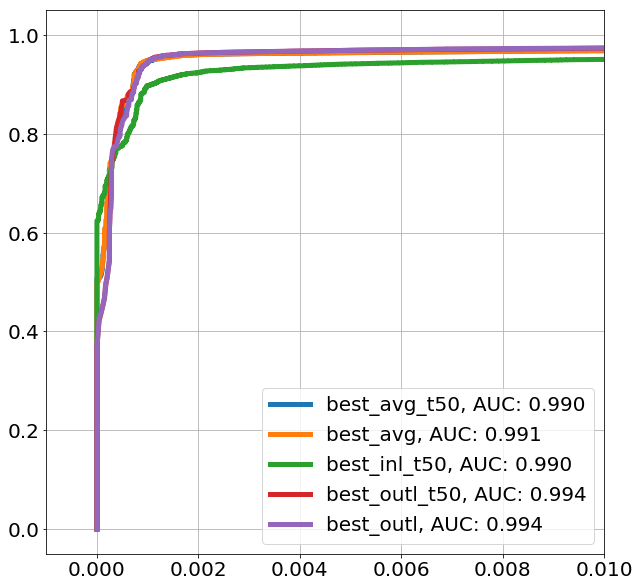

In [150]:
# print auc:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc


print('\nROC curves')
print('CP = correctly predicted')
print()

roc_curve_data = {}
with plotparams({'figure.figsize': (10, 10), 'font.size': 20}):
    for name, pred_df in pred_dfs.items():
        _pred_df = pred_df[sel_inlier(pred_df)| sel_outlier(pred_df)]
        fpr, tpr, thresholds = roc_curve(_pred_df.outlier, _pred_df.predicted_anomaly_score+offsets[name], drop_intermediate=True)
        roc_curve_data[name] = (fpr, tpr, thresholds)
        plt.plot(fpr, tpr,
                 label=name + ', AUC: %.3f' % auc(fpr, tpr),
                 linewidth=5) # , marker='o')
    plt.legend()
    plt.grid()
    plt.xlim([-0.001, 0.01])
    plt.show()

Average % correctly predicted by score threshold

best_avg_t50
TH  FPR: 1-(% of CP(inliers))  TPR: : % of CP(outliers)  % CP (mean)
0.349984                       1.00                      1.00      0.50074
0.369999                       0.63                      1.00      0.68465
0.390000                       0.31                      0.99      0.83848
0.410000                       0.16                      0.98      0.91221
0.429948                       0.08                      0.98      0.94925
0.449976                       0.04                      0.97      0.96935
0.469991                       0.02                      0.97      0.97715
0.489994                       0.01                      0.97      0.97944
0.509975                       0.00                      0.96      0.97960
0.529984                       0.00                      0.96      0.97817
0.549971                       0.00                      0.95      0.97461
0.569989                       0.00        

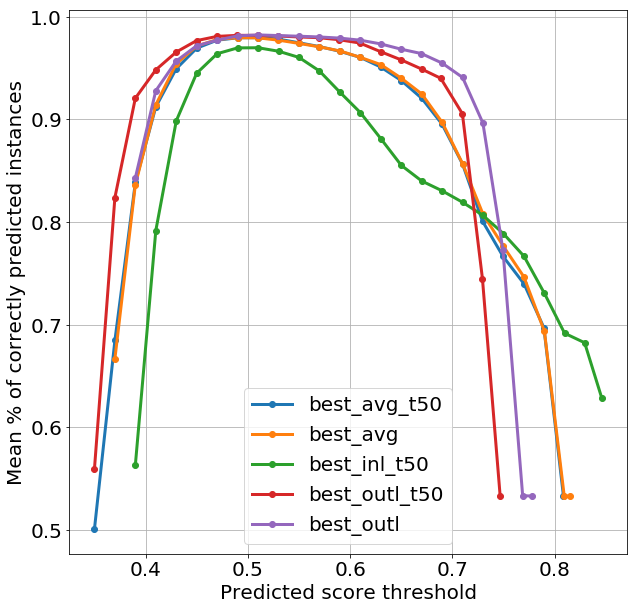

The best outlier has a borader range where the mean % of recognition is stable and higher
For that model, the plot above says that by setting thresholds between .55 and .65 you get the best percentage of correctly classified instances
The green line basically says that the optimum separation is between 0.55 and 0.65: above that threshold
the higher the score, the more likely the segment is an outlier, the lower the score, the more likely the segment is not an outlier
Setting higher or lower thresholds depends on the usage:
Lower thresholds mean the user wants to be more strict about discarding all outliers (at the cost of trhowing away some inliers, and thus more data, because inliers are in principle more) 
Higher thresholds mean the user wants to be more strict about keeping all inliers (at the cost of not trhowing away some outliers, and thus keeping more data, because outliers are in principle more) 


In [151]:
print('Average % correctly predicted by score threshold')

with plotparams({'figure.figsize': (10, 10), 'font.size': 20}):
    for name, (fpr, tpr, thresholds) in roc_curve_data.items():
        data_ = {}
        for x, y, th in zip(fpr[::-1], tpr[::-1], thresholds[::-1]):
            if th < 0 or th > 1:
                continue
            key_ = int(0.5+th*50)
            data_[key_] = (th, np.round(x,2), np.round(y,2), np.round(((1-x)+y)/2.0, 5))
        statdfr = pd.DataFrame(list(data_.values()),
                               columns=['TH', 'FPR: 1-(% of CP(inliers))', 'TPR: : % of CP(outliers)', '% CP (mean)'])
        print()
        print(name)
        print(statdfr.to_string(index=False))
        plt.plot(statdfr['TH'], statdfr['% CP (mean)'],
                 label=name,
                 linewidth=3, marker='o')
    plt.legend()
    plt.xlabel('Predicted score threshold')
    plt.ylabel('Mean % of correctly predicted instances')
    plt.grid()
    # plt.xlim([0, 0.1])
    plt.show()
    
print('The best outlier has a borader range where the mean % of recognition is stable and higher')
print('For that model, the plot above says that by setting thresholds between .55 and .65 you get the best percentage of correctly classified instances')
# print('No inlier has been classified with scores >=.62, some outlier (2%) has been classified with scores <0.52')
print('The green line basically says that the optimum separation is between 0.55 and 0.65: above that threshold')
print('the higher the score, the more likely the segment is an outlier, the lower the score, the more likely the segment is not an outlier')
print('Setting higher or lower thresholds depends on the usage:')
print('Lower thresholds mean the user wants to be more strict about discarding all outliers (at the cost of trhowing away some inliers, and thus more data, because inliers are in principle more) ')
print('Higher thresholds mean the user wants to be more strict about keeping all inliers (at the cost of not trhowing away some outliers, and thus keeping more data, because outliers are in principle more) ')


Scores distributions of unknown
SCORES DISTRIBUTIONS ON SEGMENTS: INLIERS + OUTLIERS + ME UNKNOWN
best_avg_t50


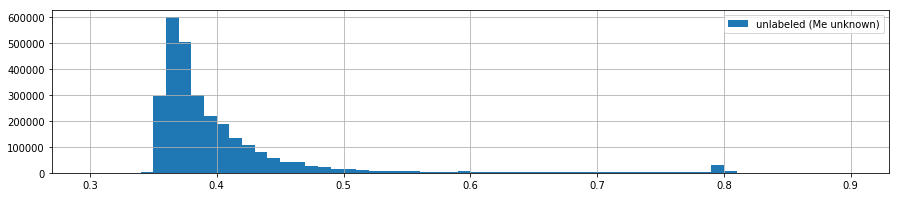

best_avg


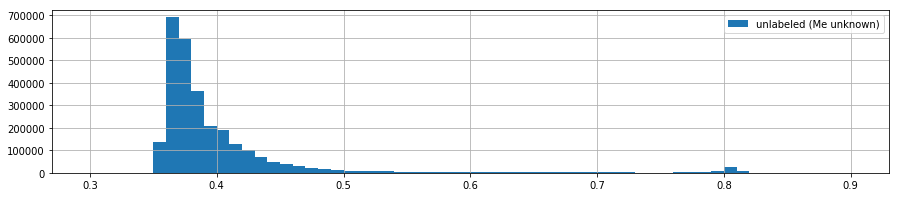

best_inl_t50


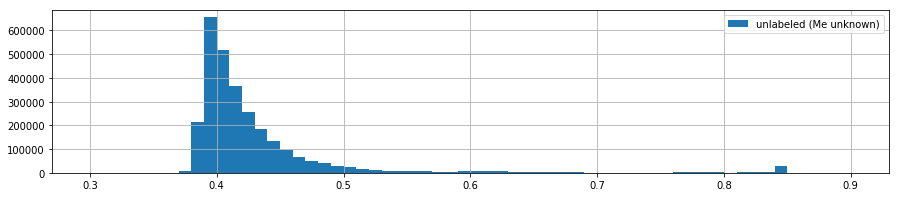

best_outl_t50


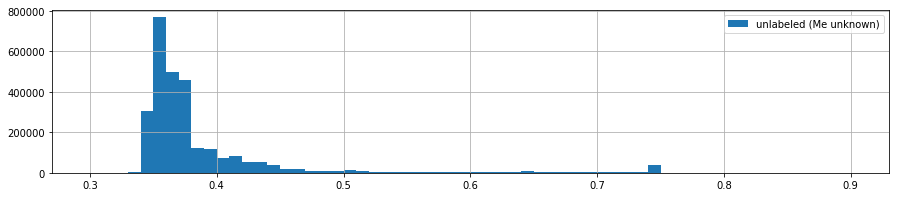

best_outl


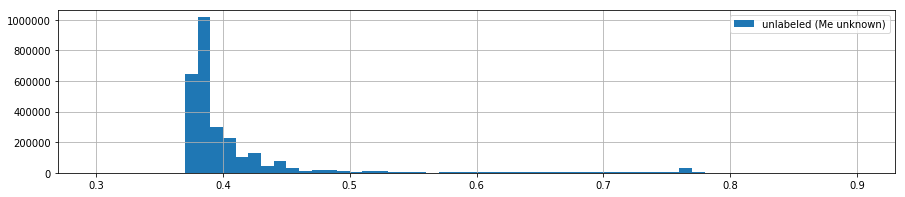

In [153]:
print('Scores distributions of unknown')

from sod.core.dataset import dataset_info, allset_test


class_inlier = allset_test.classnames[0]
class_outlier = allset_test.classnames[1]
class_me_unknown = allset_test.classnames[2]

sel_inlier = allset_test.class_selector[class_inlier]
sel_outlier = allset_test.class_selector[class_outlier]
sel_me_unknown = allset_test.class_selector[class_me_unknown]


import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)

print('SCORES DISTRIBUTIONS ON SEGMENTS: INLIERS + OUTLIERS + ME UNKNOWN')

%matplotlib inline
import numpy as np
bins = np.arange(0.3, .9, 0.01)
with plotparams({'figure.figsize': (15, 3)}):
    for name, pred_df in pred_dfs.items():
        print(name)
        data = [
            # pred_df[sel_inlier(pred_df)].predicted_anomaly_score + offsets[name],
            # pred_df[sel_outlier(pred_df)].predicted_anomaly_score + offsets[name],
            pred_df[sel_me_unknown(pred_df)].predicted_anomaly_score + offsets[name]
        ]
        
        plt.hist(data, bins=bins, log=False, histtype='bar', stacked=False, label=[class_me_unknown])
        plt.grid()
        # plt.ylim([1, 40000]) #  10**5])
        plt.legend()
        plt.show()

In [209]:
# let's try to see the max score

arr = np.array([[-10.0**_] for _ in np.arange(-20, 20)])
print(-clfs['best_outl_t50'].score_samples(arr))

arr = np.array([[-125+ (_/10.0)] for _ in np.arange(20)])
# print(arr)
print(-clfs['best_outl_t50'].score_samples(arr))



[0.81561497 0.81561497 0.81561497 0.81561497 0.81561497 0.81561497
 0.81561497 0.81561497 0.81561497 0.81561497 0.81561497 0.81561497
 0.81561497 0.81561497 0.81561497 0.81561497 0.81561497 0.81561497
 0.81561497 0.81561497 0.81561497 0.81561497 0.55503867 0.81367304
 0.81367304 0.81367304 0.81367304 0.81367304 0.81367304 0.81367304
 0.81367304 0.81367304 0.81367304 0.81367304 0.81367304 0.81367304
 0.81367304 0.81367304 0.81367304 0.81367304]
[0.41849879 0.41572067 0.41502936 0.41626825 0.4161144  0.41189393
 0.41030571 0.41307557 0.4142254  0.42078642 0.41521812 0.42041246
 0.42049516 0.41754393 0.42105658 0.42111694 0.42189423 0.41921668
 0.42559505 0.42415504]


[0.99328215 0.99526665 0.99526665 ... 0.52325581 0.03359506 0.02076309]

best_outl_t50 normal


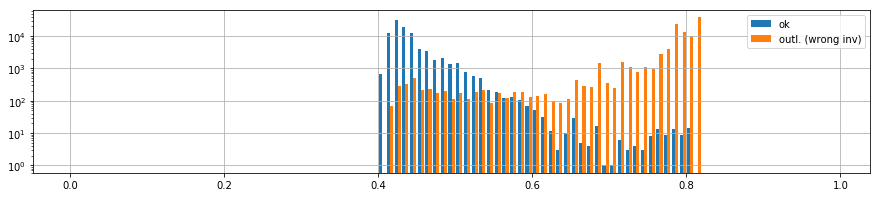

best_outl_t50 with offset


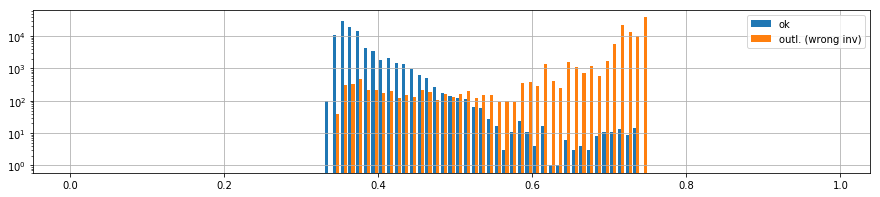

best_outl_t50 sigmoid calibrated


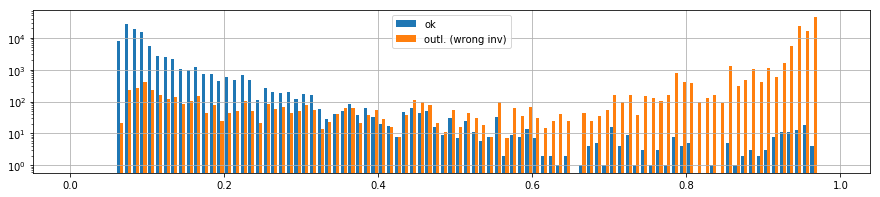

best_outl_t50 isotonic


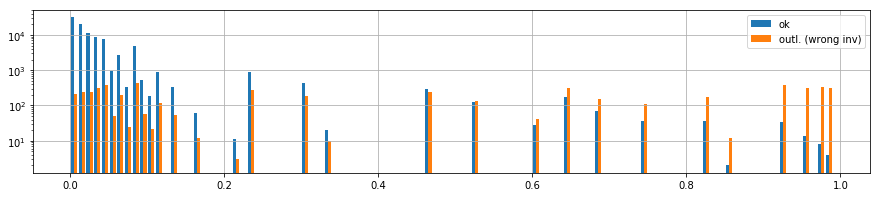

In [217]:
from sklearn.linear_model import LogisticRegression
name = 'best_outl_t50'
pred_df = pred_dfs[name]
prd_df = pred_df[sel_inlier(pred_df) | sel_outlier(pred_df)]

size = len(prd_df)
X = prd_df.predicted_anomaly_score.values.reshape(size, 1)
y = prd_df.outlier.values

lr_clf = LogisticRegression(random_state=0, solver='liblinear', C=0.01).fit(X, y)
# print(lr_clf.predict_proba(X)[:,1])
# print(y)


from sklearn.isotonic import IsotonicRegression as IR

ir = IR( out_of_bounds = 'clip')
ir.fit( prd_df.predicted_anomaly_score.values, y)
ir_calibrated = ir.transform(prd_df.predicted_anomaly_score.values)
print(ir_calibrated)

bins = np.arange(0,1,0.01)
log_ = True
print()
with plotparams({'figure.figsize': (15, 3)}):
    print(name + ' normal')
    data = [
        pred_df[sel_inlier(pred_df)].predicted_anomaly_score,
        pred_df[sel_outlier(pred_df)].predicted_anomaly_score
    ]

    plt.hist(data, bins, log=log_, histtype='bar', stacked=False, label=[class_inlier, class_outlier])
    plt.grid()
    # plt.ylim([1, 40000]) #  10**5])
    plt.legend()
    plt.show()
    
    
    print(name + ' with offset')
    data = [
        pred_df[sel_inlier(pred_df)].predicted_anomaly_score + offsets[name],
        pred_df[sel_outlier(pred_df)].predicted_anomaly_score + offsets[name]
    ]

    plt.hist(data, bins, log=log_, histtype='bar', stacked=False, label=[class_inlier, class_outlier])
    plt.grid()
    # plt.ylim([1, 40000]) #  10**5])
    plt.legend()
    plt.show()

    print(name + ' sigmoid calibrated')
    data = [
        lr_clf.predict_proba(X)[:,1][~y],
        lr_clf.predict_proba(X)[:,1][y]
    ]
    plt.hist(data, bins, log=log_, histtype='bar', stacked=False, label=[class_inlier, class_outlier])
    plt.grid()
    # plt.ylim([1, 40000]) #  10**5])
    plt.legend()
    plt.show()
    
    print(name + ' isotonic')
    data = [
        ir_calibrated[~y],
        ir_calibrated[y]
    ]
    plt.hist(data, bins, log=log_, histtype='bar', stacked=False, label=[class_inlier, class_outlier])
    plt.grid()
    # plt.ylim([1, 40000]) #  10**5])
    plt.legend()
    plt.show()

In [ ]:
# STOP HERE STOP HERE ============================================================================

In [93]:
# [1] IF YOU WANT TO SET OUTLIERS THE SEGMENTS BASED ON A HEURISTIC (MEDIAN SCORE_SAMPLES >= 0.8)
# OR ALL SCORE_SAMPLES > 0.5), UNCOMMENT THE LINES BELOW UNTIL [2]:

from collections import defaultdict

print('Taking Me unlabelled segments only')
me_pred_dfs = {n: p[sel_me_suspicious(p) | sel_me_unknown(p)] for n, p in pred_dfs.items()}

outl_staids = defaultdict(int)
inl_staids = defaultdict(int)
print('Getting stations clearly outliers and clearly inliers')
for name, _pred_df in me_pred_dfs.items():
    for station_id, df_ in _pred_df.groupby(['station_id']):
        #if (df_.predicted_anomaly_score > 0.5).all() and df_.predicted_anomaly_score.median() >= 0.7:
        if df_.predicted_anomaly_score.median() >= 0.75:
             outl_staids[station_id] += 1
        #elif (df_.predicted_anomaly_score < 0.55).all():
        elif df_.predicted_anomaly_score.median() <= 0.55:
            inl_staids[station_id] += 1

# take only the staids common to all pred_df:
outl_staids = {k :v for k, v in outl_staids.items() if v == len(me_pred_dfs)}
print('Station ids whose segments have to be set as outliers:')
o_staids = list(outl_staids.keys())
print(o_staids)

inl_staids = {k :v for k, v in inl_staids.items() if v == len(me_pred_dfs)}
print('Station ids whose segments are CLEARLY inliers:')
i_staids = list(inl_staids.keys())
print(i_staids)

# Create a new dict of pred_dfs: 
# preds = {}
# for name, pred_df in pred_dfs.items():
#     preds[name] = pred_df[pred_df.station_id.isin(i_staids) | pred_df.station_id.isin(o_staids)].copy()

# ===========================================================================
# [2] IF YOU WANT TO SET OUTLIERS THE SEGMENTS OF THE STATION IDS CALCULATED
# VIA THE COMMENTED CODE ABOVE, UNCOMMENT THE LINES BELOW:
# staids = [640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 656, 657, 658, 659, 660, 661, 662, 663, 712, 713, 714, 715, 716, 718, 719, 722, 723, 724, 725, 726, 727, 728, 729, 730, 1070, 1071, 1096, 1342, 1412, 1414, 1421, 1422, 1423, 1430, 1431, 1432, 1433, 1443, 1449, 1451, 1453, 1454, 1980, 1990, 1993, 1997, 2410, 2772, 2860, 2861, 2863, 2864, 2904, 3541, 3714, 3715, 3716, 3717, 3727, 3728, 3729, 3730, 3731]

import sod.core.dataset as sod_core_eval
importlib.reload(sod_core_eval)


print('AUTOMATIC RELABELLING OF ME unlabelled segments')
me_preds = {}
for name, _pred_df in me_pred_dfs.items():
    pred_df = _pred_df.copy()
    pred_df['outlier'] = False
    new_outliers =  pred_df.station_id.isin(o_staids)
    pred_df.loc[new_outliers, 'outlier'] = True
    pred_df.loc[new_outliers, 'subclass'] = ''  # see globalset class in sod.core.dataset
    
    new_inliers = pred_df.station_id.isin(i_staids)
    pred_df.loc[new_inliers, 'outlier'] = False
    pred_df.loc[new_inliers, 'subclass'] = ''  # see globalset class in sod.core.dataset
    
    pred_df.loc[(~new_inliers) & (~new_outliers), 'outlier'] = False
    pred_df.loc[(~new_inliers) & (~new_outliers), 'subclass'] = 'unlabeled.unknown'
    
    me_preds[name] = pred_df  # this marks all as outliers, see globalset class in sod.core.dataset


Taking Me unlabelled segments only
Getting stations clearly outliers and clearly inliers
Station ids whose segments have to be set as outliers:
[623, 712, 713, 714, 715, 716, 719, 724, 725, 726, 730, 1061, 1070, 1071, 1096, 1414, 1422, 1423, 1430, 1431, 1432, 1433, 1443, 1449, 1451, 1453, 1454, 2687, 2732, 2904, 2990, 3494, 3645, 3727, 3728, 3729, 3730, 3731]
Station ids whose segments are CLEARLY inliers:
[1, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155

In [94]:
import sod.core.evaluation as sod_core_eval
importlib.reload(sod_core_eval)

def print_cm(prediction_dataframes_dict):  # list of (cmatrix, mean_lo)

    mll = 'Mean log_loss'
    rec = '% rec.'

    for name, pred_df in prediction_dataframes_dict.items():
        cmtr = sod_core_eval.cmatrix_df(pred_df)
        # drop 'ok' segments because used for training:
        cmtr.drop(sod_core_dataset.allset_train.classnames[-2], inplace=True)
        cmtr.drop(sod_core_dataset.allset_train.classnames[-1], inplace=True)
        mean_log_loss = cmtr[mll].mean()  # (2*cmtr[mll][0] + cmtr[mll][1] + 2*cmtr[mll][2] ) /5.0 
        mean_accuracy = cmtr[rec].mean()  # (2*cmtr[rec][0] + cmtr[rec][1] + 2*cmtr[rec][2] ) /5.0 
        print(name)
        print('MEAN LOG LOSS (weighted): %.3f' % mean_log_loss)
        print('MEAN ACCURACY (%% RECOGNITION, weighted): %.3f' % mean_accuracy)
        print(cmtr.to_string())
        print()

print_cm(me_preds)

psd[.2,1,2,5] psi=4096 t=50
MEAN LOG LOSS (weighted): 0.386
MEAN ACCURACY (% RECOGNITION, weighted): 96.576
                        ok  outlier  % rec.  Mean log_loss
ok                 1813244    89539  95.294        0.55688
outl. (wrong inv)      550    25139  97.859        0.21565

psd[5] psi=1024 50
MEAN LOG LOSS (weighted): 0.387
MEAN ACCURACY (% RECOGNITION, weighted): 96.825
                        ok  outlier  % rec.  Mean log_loss
ok                 1830303    72477  96.191        0.58500
outl. (wrong inv)      653    25036  97.458        0.18986



SCORES DISTRIBUTIONS ON SEGMENTS: ME ONLY (AFTER RE-LABELLING)
psd[.2,1,2,5] psi=4096 t=50


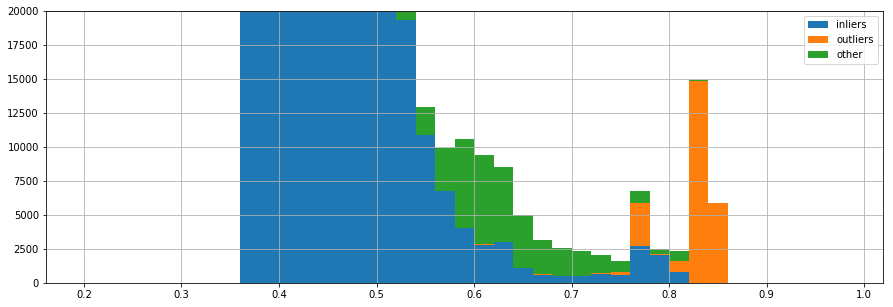

psd[5] psi=1024 50


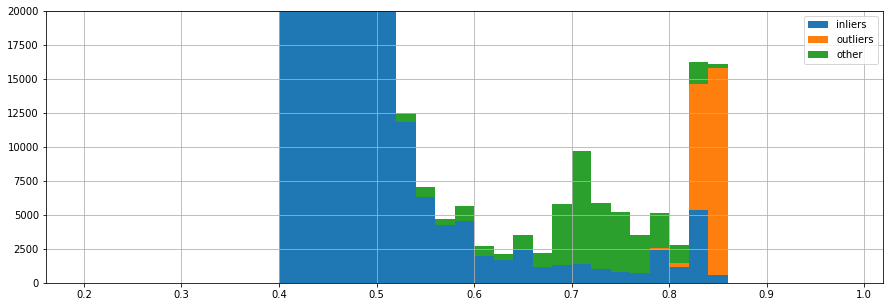

In [101]:
bins = np.arange(0.2, 1, 0.02)
data = {}
# ylims = [1, len(list(preds.values())[0])]

# sel_inlier = allset_train.class_selector[class_inlier]
# sel_outlier = allset_train.class_selector[class_outlier]
# sel_me_suspicious = allset_train.class_selector[class_me_suspicious]
# sel_me_unknown = allset_train.class_selector[class_me_unknown]

print('SCORES DISTRIBUTIONS ON SEGMENTS: ME ONLY (AFTER RE-LABELLING)')

for name, pred_df in me_preds.items():
    data[name] = {
        'inliers': pred_df[sel_inlier(pred_df)].predicted_anomaly_score,
        'outliers': pred_df[sel_outlier(pred_df)].predicted_anomaly_score,
        'other': pred_df[(~sel_inlier(pred_df)) & (~sel_outlier(pred_df))].predicted_anomaly_score
    }

with plotparams({'figure.figsize': (15, 5)}):
    for name, data_ in data.items():
        print(name)
        plt.hist(data_.values(), bins=bins, log=False, histtype='bar', stacked=True, label=data_.keys())
        plt.grid()
        plt.ylim([0, 20000])
        plt.legend()
        plt.show()

In [85]:
from sod.core import pdconcat
print('Setting station ids with outliers')
s_preds = {}
for name, pred_df in preds.items():
    preds__ = []
    for (sta_id, ds_id), df_ in pred_df.groupby(['station_id', 'dataset_id'], sort=False):
        df_row = df_[:1].copy()
        df_row.predicted_anomaly_score = df_.predicted_anomaly_score.median()
        assert df_.outlier.all() or (~df_.outlier.any())
        preds__.append(df_row)
    s_preds[name] = pdconcat(preds__)

print_cm(s_preds)

Setting station ids with outliers
psd[.2,1,2,5] psi=4096 t=50
MEAN LOG LOSS (weighted): 0.381
MEAN ACCURACY (% RECOGNITION, weighted): 99.027
                     ok  outlier  % rec.  Mean log_loss
ok                 2760       16  99.424        0.53781
outl. (wrong inv)     1       72  98.630        0.22335

psd[5] psi=1024 50
MEAN LOG LOSS (weighted): 0.380
MEAN ACCURACY (% RECOGNITION, weighted): 98.792
                     ok  outlier  % rec.  Mean log_loss
ok                 2747       29  98.955        0.57011
outl. (wrong inv)     1       72  98.630        0.18945



In [ ]:
# STO PHERE STOP HERE !!!!



ROC curves


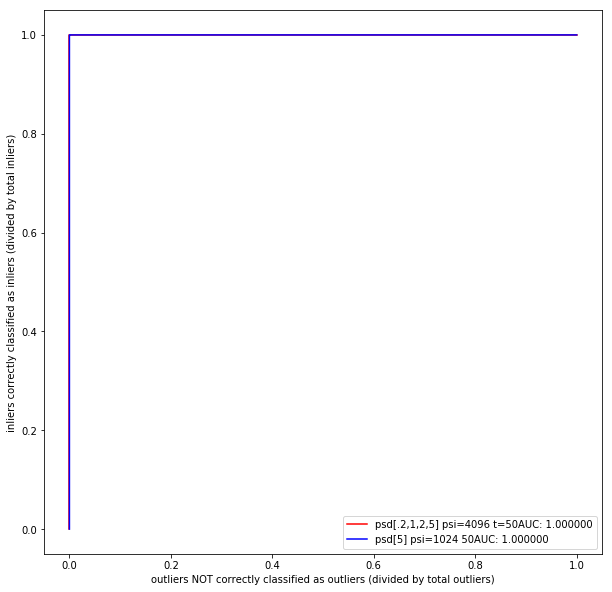

In [48]:
from sklearn.metrics import roc_curve, auc

colors = cycle(['r-', 'b-', 'g-', 'y-', 'm-', 'k-'])
with plotparams({'figure.figsize': (10, 10)}):
    for name, prd_df in preds.items():
        
        k = 'score_samples'
#         print('\n%s values of score samples (0 ok, 1=anomaly)' % str(name))
#         data = []
#         for cname, class_selector in classes.items():
#             _prd_df = prd_df[class_selector(prd_df)]
#             data.append((_prd_df[k].min(), _prd_df[k].median(), _prd_df[k].max()))
#         print(pd.DataFrame(data, columns=['min', 'median', 'max'], index=list(classes.keys())))

        roc_df = prd_df
        fpr, tpr, thresholds = roc_curve(roc_df['outlier'] * 1.0, roc_df['predicted_anomaly_score'])
        _ = next(colors)
        plt.plot(fpr, tpr, color=_[0], label=name + 'AUC: %f' % auc(fpr, tpr))
        # mxx = np.argmax(fpr*(1.0-tpr))
        # print('%s' % str([fpr[mxx], tpr[mxx]]))
        #plt.scatter(fpr[mxx], tpr[mxx], color=_[0])

    print('\nROC curves')

    plt.ylabel('inliers correctly classified as inliers (divided by total inliers)')
    plt.xlabel('outliers NOT correctly classified as outliers (divided by total outliers)')
    plt.legend()
    plt.show()

In [17]:
from sod.core import pdconcat

spreds = {}  # station predictions dataframes

groupcols = ['cha_id', 'dataset_id', 'station_id', 'location_code']
added_cols = ['subclass', 'outlier', 'score_samples', 'decision_function', 'num segs']

print('Creating stations prediction dataframes')
print(groupcols)

for name, prd_df in preds.items():
    prd_df = select(prd_df, classes)
    data = []
    for colz_vals, df in prd_df.groupby(groupcols):
        if df.empty:
            continue
        row = list(colz_vals)
        zum = df['outlier'].sum()
        assert zum == 0 or zum == len(df)
        assert len(pd.unique(df['subclass'])) == 1
        row += [df.iloc[0]['subclass'], df.iloc[0]['outlier'],
                df.score_samples.median(), df.decision_function.median(), len(df)]
        data.append(row)
    spreds[name] = pd.DataFrame(data, columns = groupcols + added_cols)
    # spreds[name] = pdconcat(data)
print('Done')

Creating stations prediction dataframes
['cha_id', 'dataset_id', 'station_id', 'location_code']
Done



CONFUSION MATRICES AT STATION LEVEL


psd[2,5] 0.1 512 | conf. matrx
                                 total  correctly predicted  mean log loss
outl. (wrong inv)                   57                   56       0.110202
unlabeled (Me suspicious outl.)     17                    7       0.308632
unlabeled (Me unknown)            2330                 2216       0.252363

psd[2,5] 0.05 2048 | conf. matrx
                                 total  correctly predicted  mean log loss
outl. (wrong inv)                   57                   56       0.115404
unlabeled (Me suspicious outl.)     17                    6       0.318409
unlabeled (Me unknown)            2330                 2226       0.246677

psd[5] 0.05 512 | conf. matrx
                                 total  correctly predicted  mean log loss
outl. (wrong inv)                   57                   56       0.102809
unlabeled (Me suspicious outl.)     17                    7       0.285931
unlabeled (Me unknown)            2330  

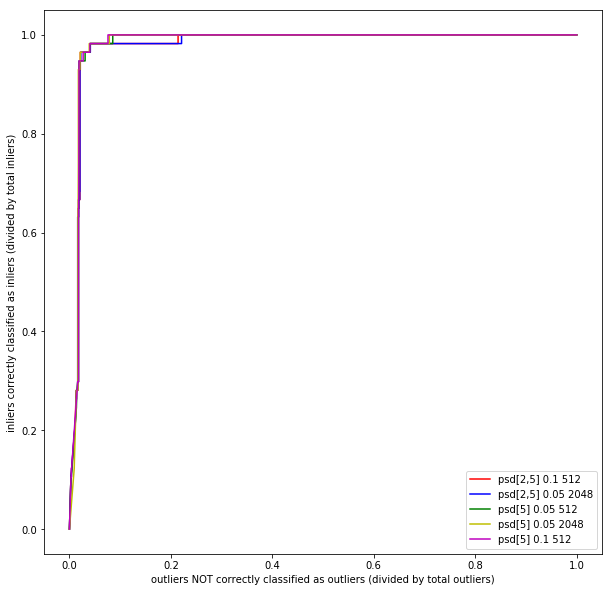

In [18]:
# from sklearn.metrics.log_loss
print('\nCONFUSION MATRICES AT STATION LEVEL\n')
for name, prd_df in spreds.items():

    k = 'score_samples'
    print('\n%s | conf. matrx' % str(name))
    data = []
    for cname, class_selector in classes.items():
        _prd_df = prd_df[class_selector(prd_df)]
        expected_class = _prd_df['outlier'].astype(float)
        if (expected_class == 1).all():
            correctly_predicted = _prd_df['score_samples'] >= 0.5
        elif (expected_class == 0).all():
            correctly_predicted = _prd_df['score_samples'] < 0.5
        else:
            raise ValueError('mixing expected classes for class %s' % cname)
        assert not np.isnan(expected_class).any()
        assert not np.isnan(correctly_predicted).any()
        assert not np.isnan(_prd_df['score_samples']).any()
        log_loss = -np.log10(np.clip(1 - np.abs(expected_class - _prd_df['score_samples']), 1e-15, 1-1e-15))
        # when expected == predicted => log_loss = 1
        # when expected=1 and predicted=0 (or viceversa) => log_loss = 0
        
        # log_loss = np.log10(log_loss)
        # print(log_loss)
        data.append([len(_prd_df), correctly_predicted.sum(), log_loss.mean()])
    print(pd.DataFrame(data, columns=['total', 'correctly predicted', 'mean log loss'], index=list(classes.keys())))




colors = cycle(['r-', 'b-', 'g-', 'y-', 'm-', 'k-'])
with plotparams({'figure.figsize': (10, 10)}):
    for name, prd_df in spreds.items():
        
        k = 'score_samples'
#         print('\n%s values of score samples (0 ok, 1=anomaly)' % str(name))
#         data = []
#         for cname, class_selector in classes.items():
#             _prd_df = prd_df[class_selector(prd_df)]
#             data.append((_prd_df[k].min(), _prd_df[k].median(), _prd_df[k].max()))
#         print(pd.DataFrame(data, columns=['min', 'median', 'max'], index=list(classes.keys())))

        roc_df = select(prd_df, rc_classes)
        fpr, tpr, thresholds = roc_curve(roc_df['outlier'] * 1.0, roc_df['score_samples'])
        _ = next(colors)
        plt.plot(fpr, tpr, color=_[0], label=name)
        # mxx = np.argmax(fpr*(1.0-tpr))
        # print('%s' % str([fpr[mxx], tpr[mxx]]))
        #plt.scatter(fpr[mxx], tpr[mxx], color=_[0])

    print('\nROC curves (only using classes: %s)' % str(rc_classnames))

    plt.ylabel('inliers correctly classified as inliers (divided by total inliers)')
    plt.xlabel('outliers NOT correctly classified as outliers (divided by total outliers)')
    plt.legend()
    plt.show()

In [19]:
colors = cycle(['r-', 'b-', 'g-', 'y-', 'm-', 'k-'])
from collections import defaultdict
# unique station keys mapped to the classifier names for which the station is misclassified:
# many_wrong = defaultdict(list)
# for name, prd_df in spreds.items():   
#     prd_df_msclf = prd_df[prd_df.outlier != (prd_df.score_samples > 0.5)]
#     for data in zip(*[prd_df_msclf[_] for _ in groupcols]):
#         many_wrong[data].append(name)
#         print(data)
#         raise
#     print('\n\n%s: %d misclassified (0 ok, 1=anomaly)\n' % (str(name), len(prd_df_msclf)))
#     print(prd_df_msclf.to_string(index=False))

for name, prd_df in spreds.items():   
    prd_df_msclf = prd_df[prd_df.outlier != (prd_df.score_samples > 0.5)]
    print('\n\n%s: %d misclassified (score_samples: 0=ok, 1=anomaly)\n' % (str(name), len(prd_df_msclf)))
    prd_df_msclf.drop(['decision_function'], 1, inplace=True)
    print(prd_df_msclf.sort_values(by=['subclass', 'score_samples']).to_string(index=False))



psd[2,5] 0.1 512: 125 misclassified (score_samples: 0=ok, 1=anomaly)

cha_id  dataset_id  station_id location_code                 subclass  outlier  score_samples  num segs
   BH           2        3258                                            True       0.433563       712
   BH           2        3246                unlabeled.maybe.outlier     True       0.408503      1071
   BH           2         434                unlabeled.maybe.outlier     True       0.409318       665
   BH           2        3242                unlabeled.maybe.outlier     True       0.409742       601
   BH           2        1126                unlabeled.maybe.outlier     True       0.410985      2463
   BH           2        3225                unlabeled.maybe.outlier     True       0.411132       855
   BH           2        2893                unlabeled.maybe.outlier     True       0.422111       507
   BH           2        1210                unlabeled.maybe.outlier     True       0.425650      2607


JUST A TRY WITH FAKE DATA


ROC curves classifier with better REC RATE, worst scores


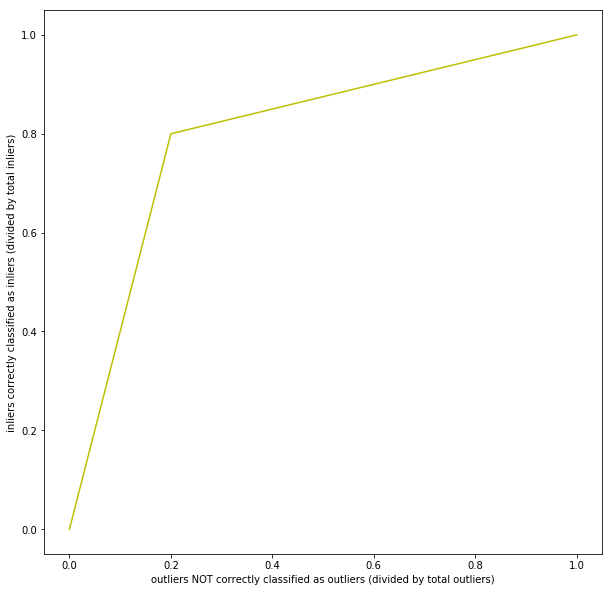


ROC curves classifier with worse REC RATE, better scores


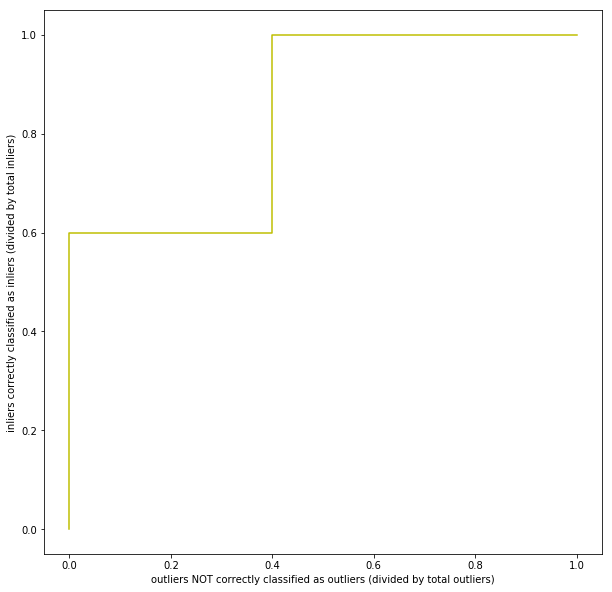

In [12]:
# let's make a try:
y_true = [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
y_pred = [0] * 4 + [1, 0] + [1]*4

print('JUST A TRY WITH FAKE DATA\n')
with plotparams({'figure.figsize': (10, 10)}):

    print('\nROC curves classifier with better REC RATE, worst scores')
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, color=_[0])
    plt.ylabel('inliers correctly classified as inliers (divided by total inliers)')
    plt.xlabel('outliers NOT correctly classified as outliers (divided by total outliers)')
    plt.show()

y_true = [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
y_pred = [0] * 3 + [0.6, 0.6, 0.4, 0.4] + [1] * 3

with plotparams({'figure.figsize': (10, 10)}):

    print('\nROC curves classifier with worse REC RATE, better scores')
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, color=_[0])
    plt.ylabel('inliers correctly classified as inliers (divided by total inliers)')
    plt.xlabel('outliers NOT correctly classified as outliers (divided by total outliers)')
    plt.show()

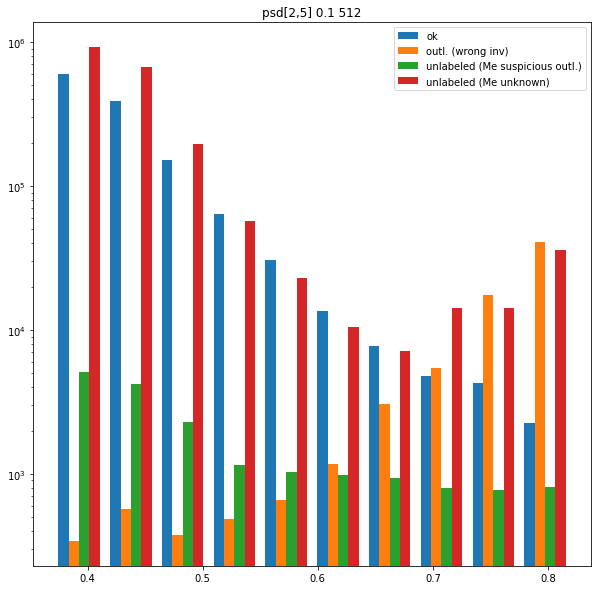

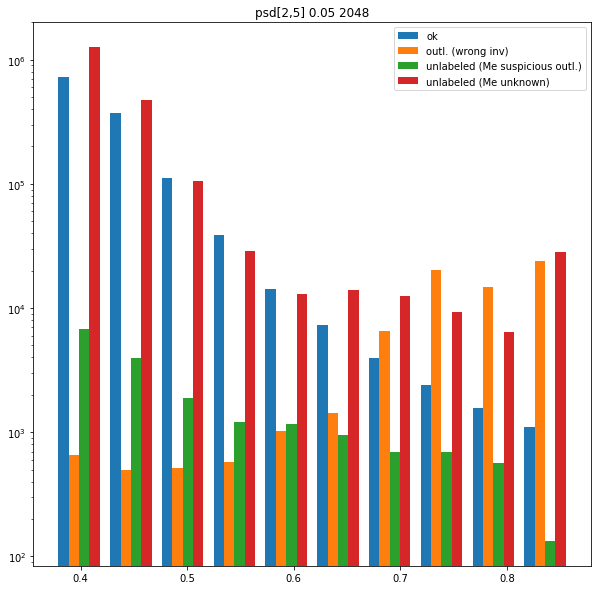

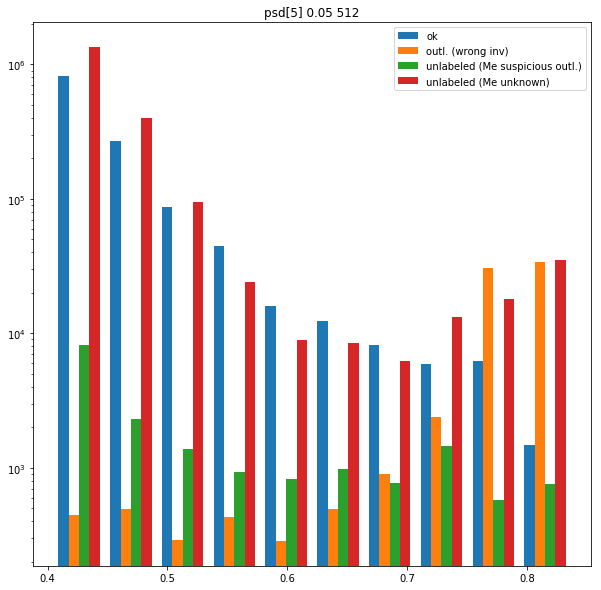

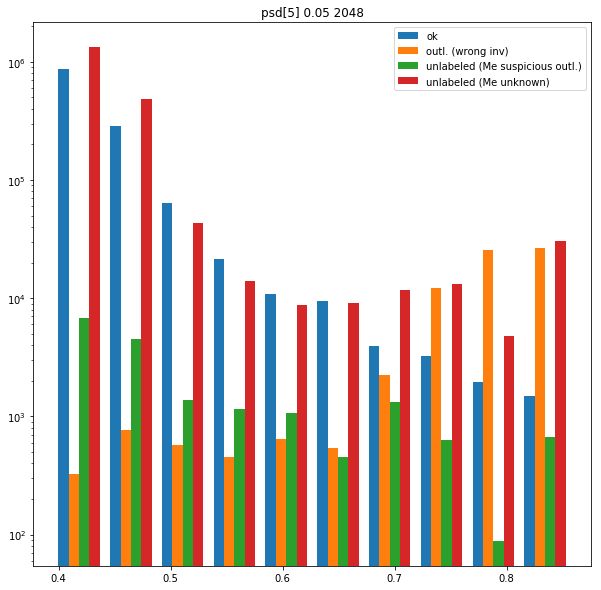

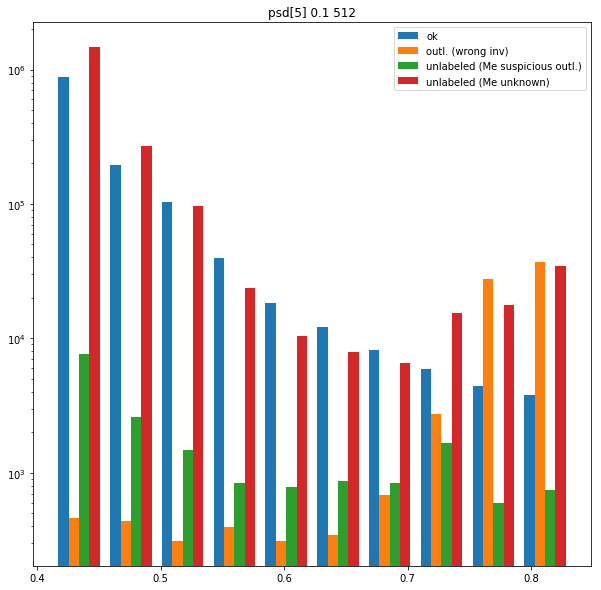

In [20]:
classnames = sod_core_dataset.allset_train.classnames
classes = {_: sod_core_dataset.allset_train.class_selector[_] for _ in classnames}

with plotparams({'figure.figsize': (10, 10)}):
    for name, prd_df in preds.items():
        data = []
        for cname, csel in classes.items():
            data.append(prd_df[csel(prd_df)]['score_samples'])
        plt.hist(data, stacked=False, log=True)  #
        plt.title(name)
        plt.legend(list(classnames))
        plt.show()
#         prd_df_msclf = prd_df[prd_df.outlier != (prd_df.score_samples > 0.5)]
#         print('\n\n%s: %d misclassified (score_samples: 0=ok, 1=anomaly)\n' % (str(name), len(prd_df_msclf)))
#         prd_df_msclf.drop(['decision_function'], 1, inplace=True)
#         print(prd_df_msclf.sort_values(by=['subclass', 'score_samples']).to_string(index=False))

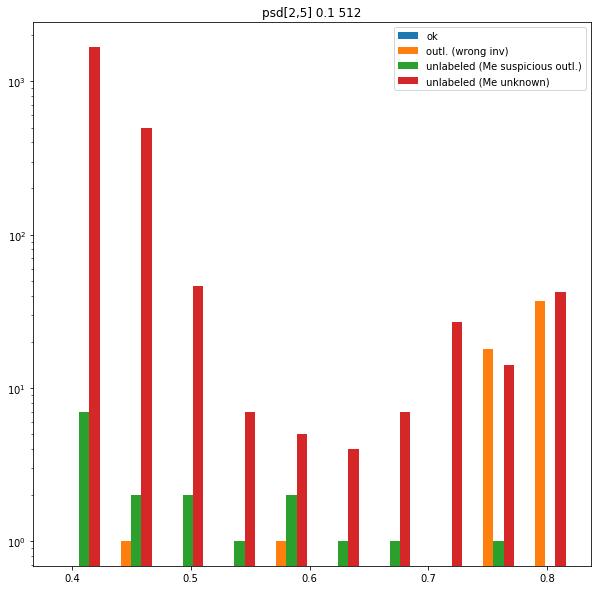

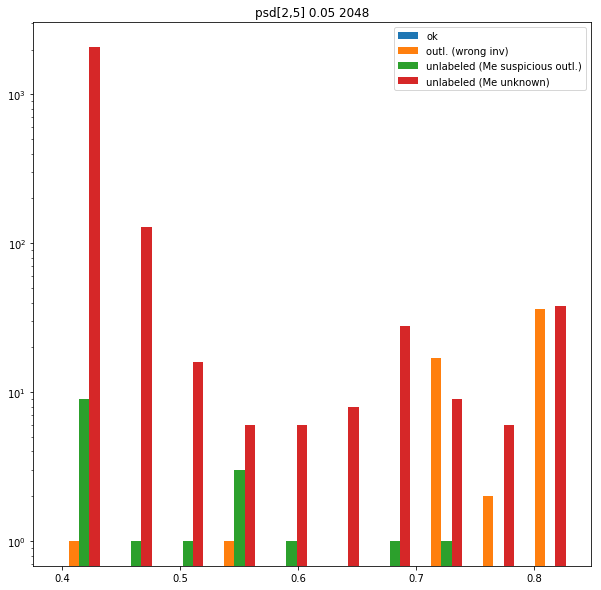

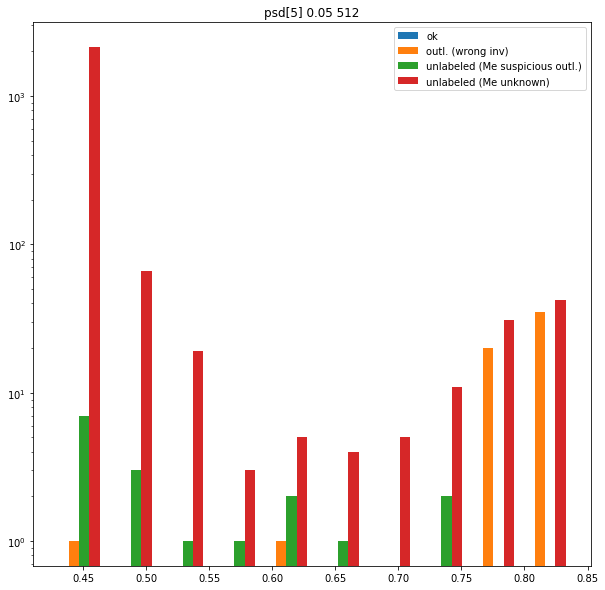

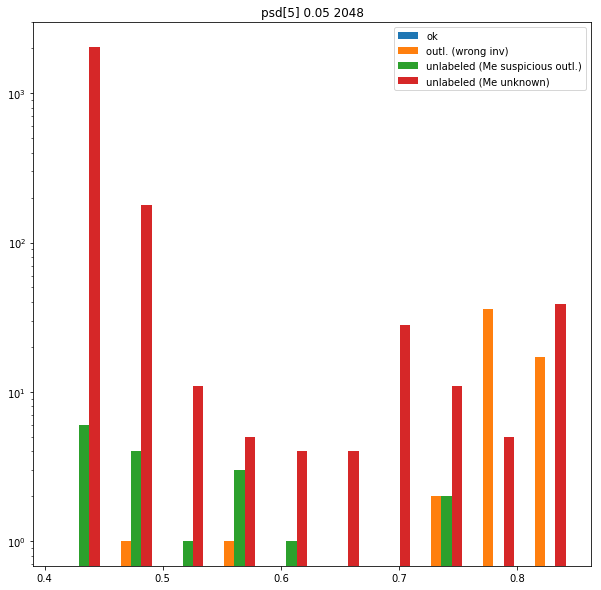

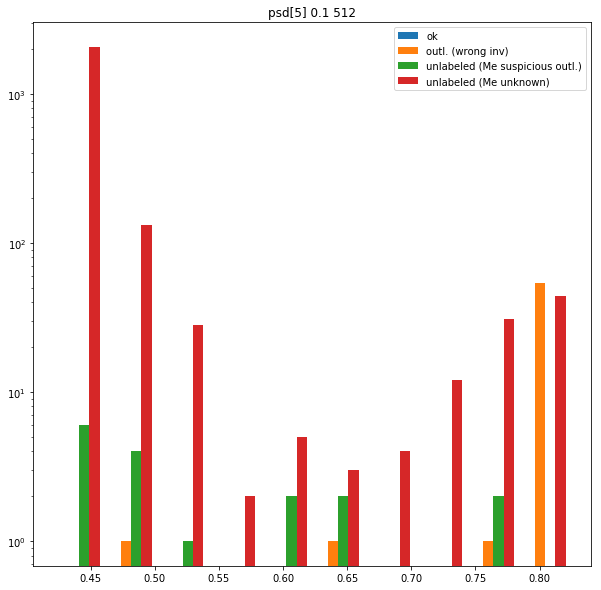

In [21]:
classnames = sod_core_dataset.allset_train.classnames
classes = {_: sod_core_dataset.allset_train.class_selector[_] for _ in classnames}

with plotparams({'figure.figsize': (10, 10)}):
    for name, prd_df in spreds.items():
        data = []
        for cname, csel in classes.items():
            data.append(prd_df[csel(prd_df)]['score_samples'])
        plt.hist(data, stacked=False, log=True)  #
        plt.title(name)
        plt.legend(list(classnames))
        plt.show()


Performances

Estimating performances


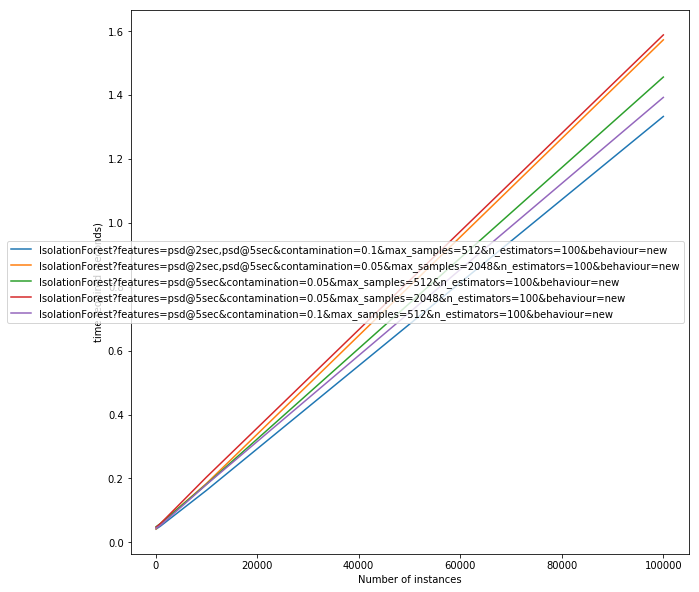

In [23]:
# adding now the two best overall:
import time
from sod.core.evaluation import _predict
# clfs = {k: load(os.path.join(root, 'models', v + '.model')) for k, v in fnames.items()}


with plotparams({'figure.figsize': (10, 10)}):

    print('\nPerformances')

    numinst = (100, 1000, 10000, 100000)
    dfs = {_: dataframe.iloc[np.random.randint(0, len(dataframe), _)].dropna() for _ in numinst}
    print('\nEstimating performances')
    for name, clf in clfs.items():
        feats = fnames[name]
        feats = feats[feats.find('features=') + len('features='):].split('&')[0].split(',')
        # print(feats)
        plotdata = []
        for test in numinst:
            ints = np.random.randint(0, len(dataframe), test)
            # dataf = dataframe.iloc[ints]
            test_df = dfs[test][feats]
            t = time.time()
            #print(dataf[feats])
            # raise
            prd = _predict(clf, test_df)
            t = time.time() - t
            plotdata.append(t)
        plt.plot(numinst, plotdata, label=fnames[name])
    plt.xlabel('Number of instances')
    plt.ylabel('time required (seconds)')
    plt.legend()
plt.show()



In [ ]:
# fare un boxplot asse x: tempo, asse y: score_samples